This can be run [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework-2/blob/main/HW2_1_OptimizationAndNetworkArchitecture.ipynb)

<font size='6'>**Homework 2.1: Training a Deep Network**</font>

** I REALIZED THE PRINT FUNCTIONALITY TRUNCATES THE PDF FILE SOMETIMES, SO PLEASE REFER TO THE LINKS BELOW TO ACCESS THE COLAB OR GITHUB VERSION IF ANYTHING UNCLEAR**

**COLAB LINK BELOW**

https://drive.google.com/file/d/1lXRh2A8a0aFWvkNA6Vgj_iUN2FK5QbyD/view?usp=sharing

**GITHUB LINK BELOW**

https://github.com/babelpainterwell/Adam-Optimizer-Implementation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# drive.flush_and_unmount()

# Overview

We will start by exploring the optimization aspects of deep network training. Throughout this journey, you will gain insights into:

**Part 1:**
- The fundamentals of simple gradient descent.
- The concept of weight decay.
- A deep understanding of PyTorch autograd and PyTorch optimizers.

**Part 2:**
- Analyzing raw gradients, means, and RMS (Root Mean Square).
- Delving into exponential moving averages.
- Exploring the workings of the ADAM optimization algorithm.

**Part 3:**
- Strategies for optimizing neural network parameters.
- Selecting appropriate nonlinearities, architectures, and layers to tackle the vanishing gradient problem.
- Leveraging techniques like regularization, parameterization, and specific layer choices to enhance generalization.
- Unpacking the roles and impacts of ADAM, ReLU activation, weight decay, network depth, network width, residual architectures, and batch normalization in deep learning.

#Note

<font size='4'>  
- **You do not need to tune hyper parameters in the regular tasks.**

- **You do not install any additional packages inside the Colab environment.**  

- **If you collaborate or get assistance from classmates, online resources, AI, or other sources, then you must then you must explicitly write down the sources that you used to credit them.**

- **Attend office hours and make post on Piazza if you have any questions.**

- **You have sufficient time to work on this assignment. Please refrain from asking for extensions.**

</font>


<font size='5'>**Setup**</font>

In [ ]:
# import sys
# # sys.path.append('/content/drive/MyDrive/hw2')
# sys.path.pop()
# print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [1]:
# Import Libraries

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib
from torch.nn import Sequential, Module
from matplotlib import pyplot as plt
from scipy.stats import norm
from hw2utils import LossFunctionWithPlot, ConstantVectorNetwork

In [2]:
class LossFunctionWithPlot:
    # A simple loss function that tracks a history each time it is called
    def __init__(self, bowl=None):
        if bowl is None:
            bowl = torch.tensor([[2.3, -0.3], [-0.5, 0.2]])
            # bowl = torch.tensor([[6.410, -0.8317], [-3.844, -0.1035]])
        self.bowl = bowl
        self.track = []
        self.losses = []

    def __call__(self, x):
        loss = torch.mm(self.bowl, x[:,None]).norm()
        self.track.append(x.detach().clone())
        self.losses.append(loss.detach())
        return loss

    def plot_history(self, grads=None, mean_grads=None, rms_grads=None):
        # Draw the contours of the objective function, and x, and y
        if grads is not None:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
        else:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
        for size in torch.linspace(0.01, 4.0, 41):
            angle = torch.linspace(0, 6.3, 100)
            circle = torch.stack([angle.sin(), angle.cos()])
            ellipse = torch.mm(torch.inverse(self.bowl), circle) * size
            ax1.plot(ellipse[0,:], ellipse[1,:], color='skyblue')
        track = torch.stack(self.track).t()
        ax1.set_title('progress of x')
        ax1.plot(track[0,:], track[1,:], marker='o')
        ax1.set_ylim(-1.6, 1.6)
        ax1.set_xlim(-1.6, 1.6)
        ax1.set_ylabel('x[1]')
        ax1.set_xlabel('x[0]')
        ax2.set_title('progress of loss')
        ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        ax2.plot(range(len(self.losses)), self.losses, marker='o')
        ax2.set_ylabel('loss')
        ax2.set_yscale('log', base=2)
        ax2.set_xlabel('iteration')
        if grads is not None:
            if isinstance(grads, list):
                grads = torch.stack(grads)
            ax3.set_title('progress of x[0] component of gradient')
            ax3.plot(range(len(grads)), grads[:,0], marker='o')
            ax3.set_ylabel('$\partial L/\partial x_0$')
            ax3.set_ylim(grads.abs().max() * -1.1, grads.abs().max() * 1.1)
            ax3.set_xlabel('iteration')
            if mean_grads is not None:
                ax3.axhline(mean_grads[0], label='mean', color='orange',
                        linestyle='--', linewidth=0.7)
                ax3.legend()
            if rms_grads is not None:
                ax3.axhline(rms_grads[0], label='rms', color='red', linewidth=0.5)
                ax3.legend()
            ax4.set_title('progress of x[1] component of gradient')
            ax4.plot(range(len(grads)), grads[:,1], marker='o')
            ax4.set_ylabel('$\partial L/\partial x_1$')
            ax4.set_ylim(grads.abs().max() * -1.1, grads.abs().max() * 1.1)
            ax4.set_xlabel('iteration')
            if mean_grads is not None:
                ax4.axhline(mean_grads[1], label='mean', color='orange',
                        linestyle='--', linewidth=0.7)
                ax4.legend()
            if rms_grads is not None:
                ax4.axhline(rms_grads[1], label='rms', color='red', linewidth=0.5)
                ax4.legend()
        fig.show()

class ConstantVectorNetwork(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.dimension = len(args)
        for i, a in enumerate(args):
            setattr(self, f'c{i}', torch.nn.Parameter(torch.tensor(a)))
    def forward(self):
        return torch.stack([
            getattr(self, f'c{i}')
            for i in range(self.dimension)])

<font size='5'>**Part 1: Simple Gradient Descent**</font>


Gradient descent is an iterative optimization algorithm for finding the minimum of a function. It works by starting at a point and then moving in the direction of the steepest descent until it reaches a minimum. The steepest descent is the direction in which the function is decreasing most rapidly.

To train a model using gradient descent, we start with a set of initial parameters. These parameters are the values of the variables in the model. We then repeatedly apply gradient descent to update the parameters. Each update moves the parameters in the direction of the steepest descent. This continues until the parameters converge to a minimum of the function.

The choice of the learning rate is important for gradient descent. The learning rate is the size of the steps that are taken in the direction of the steepest descent. If the learning rate is too small, the algorithm will converge slowly. If the learning rate is too large, the algorithm may diverge and never converge.

Let's say we have a function $\mathcal{L}(x)$ that we want to minimize. The gradient of $\mathcal{L}(x)$ is a vector that points in the direction of the steepest descent of $f(x)$. The gradient can be calculated using the following equation:

\begin{align*}
\nabla \mathcal{L}(x) &= \begin{bmatrix}
\frac{\partial \mathcal{L}(x)}{\partial x_1} \\
\frac{\partial \mathcal{L}(x)}{\partial x_2} \\
\vdots \\
\frac{\partial \mathcal{L}(x)}{\partial x_n}
\end{bmatrix} \\
\end{align*}

The gradient descent algorithm can be used to minimize f(x) by repeatedly taking steps in the direction of the gradient. The update rule for gradient descent is given by the following equation:

\begin{equation}
x_\text{new} = x_\text{old} - \alpha \cdot \nabla \mathcal{L}(x_\text{old})
\end{equation}

where $x_\text{old}$ is the current value of $x$, $x_\text{new}$ is the new value of $x$, $\alpha$ is the learning rate, and $\nabla \mathcal{L}(x_\text{old})$ is the gradient of $\mathcal{L}(x)$ evaluated at $x_\text{old}$.

<font size='4'>**Simple Implementation of Gradient Descent on a quadratic loss**</font>

Below we demonstrate gradient descent optimization in action.

We iteratively update the `x` to try to minimize a quadratic function `L` defined by the `LossFunctionWithPlot` class. The trajectory of updates and corresponding losses are stored and plotted to visualize the optimization progress.

Provide an implementation of simple gradient descent below.  In 21 steps you can make the loss go down to about 3 or better, and drive `x` somewhat towards the center of the minimum of the loss function.

 * Use `loss.backward()` (read https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html)
 * Use `x.grad` to get the gradient.
 * Update `x` in-place using `x -= `*something*, and know why `torch.no_grad()` is needed.
 * Understand why gradients need to be zeroed: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch


<font size='4' color='Red'>Task 1.1 - Implement simple gradient descent ( 1 point)</font>

Loss at step 0 is 3.937
Loss at step 7 is 0.126
Loss at step 14 is 0.293
Loss at step 21 is 0.282
Loss at step 28 is 0.283
Loss at step 35 is 0.283
Loss at step 42 is 0.283
Loss at step 49 is 0.283


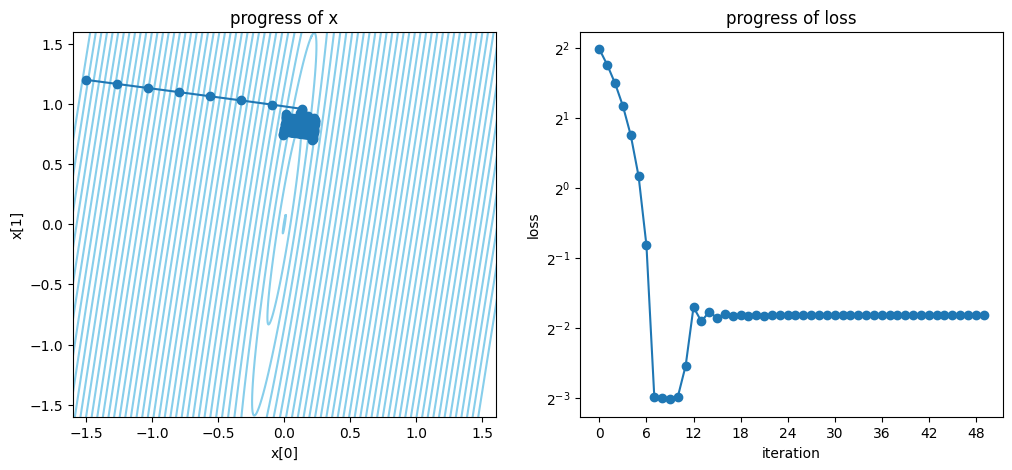

In [3]:
# Do not change the starting x.
x = torch.tensor([-1.5, 1.2])
x.requires_grad = True
L = LossFunctionWithPlot()

# Start by using a learning rate of 0.1.
learning_rate = 0.1

for iter in range(50):
    loss = L(x)
    if iter % 7 == 0: print(f'Loss at step {iter} is {loss.item():.3f}')
    loss.backward()
    with torch.no_grad():
    ############################################################################
    # TODO: Implement Simple Gradient Descent and update variable 'x'
    # Read Documentation to compute a gradient of a parameter -
    # https://pytorch.org/docs/stable/autograd.html
    ############################################################################
      # using x = x - learning_rate * x.grad creates a new tensor
      # update x in place
      x -= learning_rate * x.grad
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    x.grad = None
L.plot_history()

One reason it is hard for gradient descent to move towards the bottom of the bowl is that there is no single ideal learning rate for all dimensions.  In the problem in 1.1, notice that:
 * the loss changes direction very quickly (the curvature is high) in the horiztonal direction of `x[0]`
 * the loss is very slow-changing (the curvature is lower) in the vertical direction of `x[1]`.

The "sawtooth" loss curves and the "zig-zag" paths are symptoms of an optimizer that is taking steps that are too large: the path could be repeatedly jumping over a valley in the loss surface and ending up at another point of high, or even higher loss.  A lower learning rate can help, but it can lead to another problem. (What problem?  Try it.)

Another fancy idea is to mix learning rates, with different learning rates for each parameter.  Although you can still make a learning rate too high or too low.

<font size='4' color='red'> Task 1.2 - Explore Simple Gradient Descent using various learning rates (_ points)</font>

Now copy your code from 1.1 below here, but **experiment with learning rates**, including **unequal learning rates** for `x[0]` and `x[1]` by setting to a tensor with two values.  Try to find a pair of learning rates that move $x$ to the bottom of the bowl and stays there with near-zero loss.

Loss at step 0 is 3.937
Loss at step 7 is 3.089
Loss at step 14 is 2.242
Loss at step 21 is 1.394
Loss at step 28 is 0.548
Loss at step 35 is 0.058
Loss at step 42 is 0.061
Loss at step 49 is 0.060


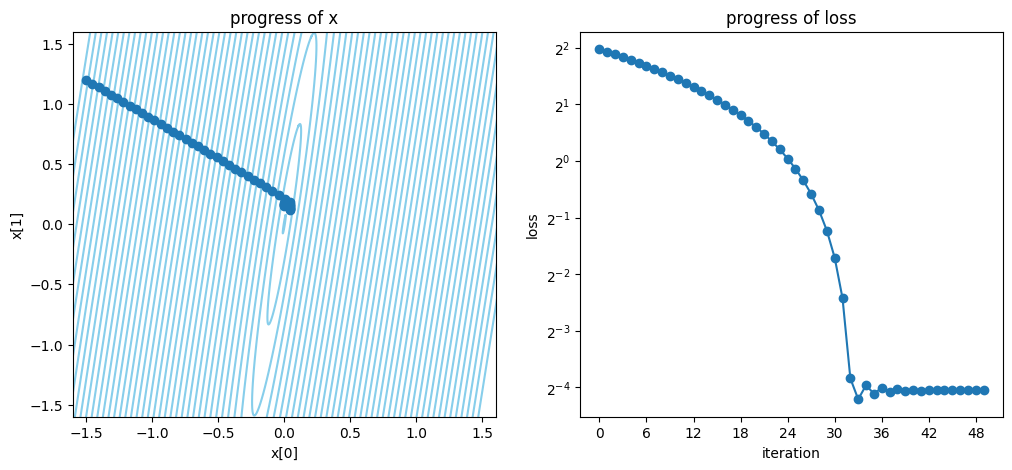

In [4]:
################################################################################
# TODO: Copy your solution from Task 1.1 here and attempt to discover a pair of
# learning rates that guide the optimization process to place 'x' at the lowest
#point of the bowl and maintain it there with a nearly zero loss.
################################################################################
# Do not change the starting x.
x = torch.tensor([-1.5, 1.2])
x.requires_grad = True
L = LossFunctionWithPlot()

# Start by using a learning rate of 0.1.
# learning_rate = 0.1
learning_rate = torch.tensor([0.02, 0.09])

for iter in range(50):
    loss = L(x)
    if iter % 7 == 0: print(f'Loss at step {iter} is {loss.item():.3f}')
    loss.backward()
    with torch.no_grad():
      x -= learning_rate * x.grad
      # x[0] -= learning_rate[0] * x.grad[0]
      # x[1] -= learning_rate[1] * x.grad[1]
    x.grad = None
L.plot_history()

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='red'>**Inline Question 1.A ( 1 point ):** What bad things tend to happen when the learning rate is too high? </font>

**Answer**:

$$\text{When the learning rate is too high } \fbox{it's likely to overshoot the global minimum or oscillate around the minimum}$$

<font size='4' color='red'>**Inline Question 1.B ( 1 point ):**  What bad things tend to happen when the learning rate is too low?</font>

**Answer**:

$$\text{When the learning rate is too low } \fbox{the learning process tends to be very slow and cannot converge within given time budget}$$

<font size='4' color='red'>**Inline Question 1.C (1 point):**  Should a higher or lower learning rate be used on a dimension with higher curvature (with sharper changes)?</font>

**Answer**:

$$\text{When the dimension has higher curvature, the learning rate should generally be } \fbox{lower to prevent overshoot and avoid divergence}$$

<font size='4'>**II) Weight Decay, aka L2 regularization**</font>

Weight decay, aslo known as L2 regularization, adds the following term to the total loss:

\begin{equation}
\mathcal{L}(\theta) = \mathcal{L}_\text{objective}(\theta) + \frac{\lambda}{2\nu} |\theta|^2
\end{equation}

where:

- $\mathcal{L}(\theta)$ - is the regularized objective function.
- $\mathcal{L}_\text{objective}(\theta)$ - is the original objective function (without regularization).
- $\theta$ is the vector of model parameters.
- $\lambda$ is the regularization parameter.
- $\nu$ is the learning rate being used.


<font size='4' color='red'>**1.D) Inline Question (1 point):** What is the gradient $\nabla L(\theta)$ in terms of $\nabla \mathcal{L}_\text{objective}(\theta)$ and $\theta$?</font>

$$ \fbox{Answer: $∇ L_\text{objective}(θ) + \frac{λ}{v} θ$}$$



<font size='4' color='red'>**1.E) Inline Question (1 point):** Suppose 'ν' is the learning rate. Then what should be the update rule for Θ?</font>

<!-- $$ \fbox{Answer: v \times ∇\mathcal{L}_\text{objective}   }$$ -->
$$ v × (∇\mathcal{L}_\text{objective} + \frac{λ}{v}θ )= v × ∇\mathcal{L}_\text{objective} + λθ$$



<font size='4' color='Red'>Task 1.3 - Implement a `SimpleGradientDescent` optimizer class in pytorch (2 point)</font>


Pytorch encapsulates optimization algorithms into optimizer classes that hold on to a list of parameters being optimized, and that update the parameters in-place based on gradients using a `step()` method.

Here we see how that pattern works.

Implement the `SimpleGradientDescent` class as a pytorch-style optimizer by completing the code below.

Incorporate weight decay by adding the term you computed above, where $\lambda$ is the `weight_decay` hyperparameter.

Loss at step 0 is 3.937
Loss at step 7 is 0.126
Loss at step 14 is 0.288
Loss at step 21 is 0.282
Loss at step 28 is 0.283
Loss at step 35 is 0.283
Loss at step 42 is 0.283
Loss at step 49 is 0.283


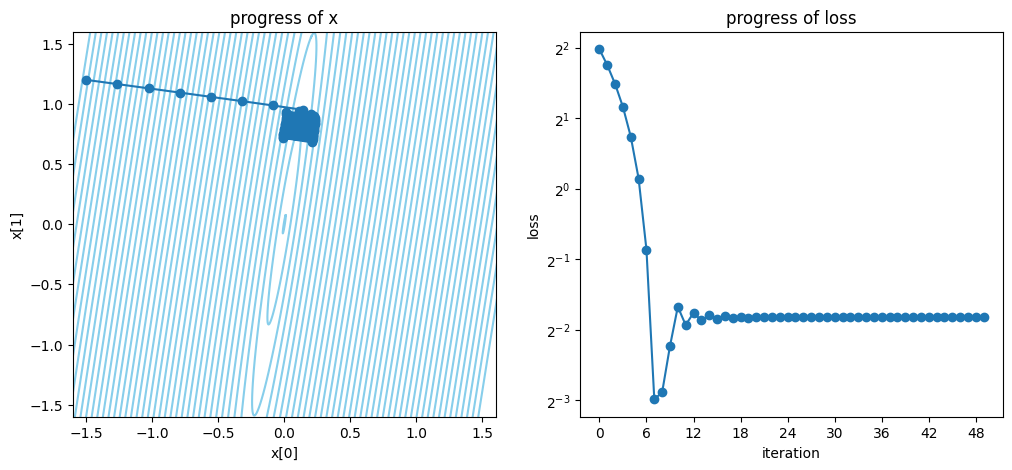

In [5]:
class SimpleGradientDescent():
    def __init__(self, parameters, lr=0.1, weight_decay=0.0):
        self.lr = lr
        self.weight_decay = weight_decay
        self.parameters = []
        for x in parameters:
            self.parameters.append(x)
    def step(self):
      with torch.no_grad():
            for x in self.parameters:
        ########################################################################
        # TODO:  Implement Simple Gradient Descent with the inclusion of
        # weight_decay, and then update the results in variable x.
        ########################################################################
                # x: weight parameter
                # from 1.D
                x -= (self.lr * x.grad + self.weight_decay * x)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
    def zero_grad(self):
        for x in self.parameters:
            x.grad = None

x = torch.tensor([-1.5, 1.2])
x.requires_grad = True # This tells PyTorch that the x variable will be used to calculate gradients.

L = LossFunctionWithPlot()

learning_rate = 0.1
optimizer = SimpleGradientDescent([x], lr=learning_rate, weight_decay=1e-3)

for iter in range(50):
    loss = L(x)
    if iter % 7 == 0: print(f'Loss at step {iter} is {loss.item():.3f}')
    loss.backward()
    with torch.no_grad():
        optimizer.step()
    optimizer.zero_grad()

L.plot_history()

##<font size='5'>**Part 2: The ADAM optimizer**</font>

<font size='4'>**I) Analyzing Raw Gradients, Means, and RMS (Root Mean Square).**</font>

<font size='4'>**Measure mean of the gradient on each dimension**</font>

First, let us plot and examine the mean of the gradient.

Using the code below as a starting point, calculate and fill in the following mean gradient over the 50 iterations in the specific optimization below:

$$\mathtt{mean\_grads[i]} = \frac{1}{N} \sum_{t=1}^N \frac{\partial \mathcal{L}}{\partial x_i}(x^{(t)})$$

<font size='4' color='red'>**2.A) Inline Questions (2 points):**</font>

$$\text{1. Mean gradient component with respect to x[0]} = -0.2982$$
$$\text{2. Mean gradient component with respect to x[1]} = 0.0940$$


<font size='4'>**Measure root-mean-square of the gradient on each dimension**</font>

Second, let's plot the root mean square (RMS) of the gradient.

Using the code below as a starting point, calculate and fill in the following root-mean-square gradient over the 50 iterations in the specific optimization below:

$$\mathtt{rms\_grads[i]} = \sqrt{\frac{1}{N} \sum_{t=1}^N \left(\frac{\partial \mathcal{L}}{\partial x_i}(x^{(t)})\right)^2}$$

<font size='4' color='red'>**2.B) Inline Questions (2 points):**</font>

$$\text{ 1. RMS gradient component with respect to x[0]} = 2.1092$$

$$\text{ 2. RMS gradient component with respect to x[1]} = 0.3078$$



 <font size='4'>**Understanding the challanges faced by simple gradient descent.**</font>

The optimization problem in Part I causes gradient descent to run into a few different problems:
 * after initially descending  the loss jumps back up.
 * after making initial quick progress, $x$ gets stuck instead of heading towards the middle.

<font size='4' color='Red'>Task 2.1 Insights from Raw Gradient Plots and Statistical Metrics (2 points)</font>

To understand the problems, run the code below to see plots of the raw gradient, and then compute the Mean and root-mean-square (RMS) of each component of the gradient over all the iterations.


Mean grads for two dimensions separately: tensor([-0.2982,  0.0940])
Root mean square grads for two dimensions separately: tensor([2.1092, 0.3078])


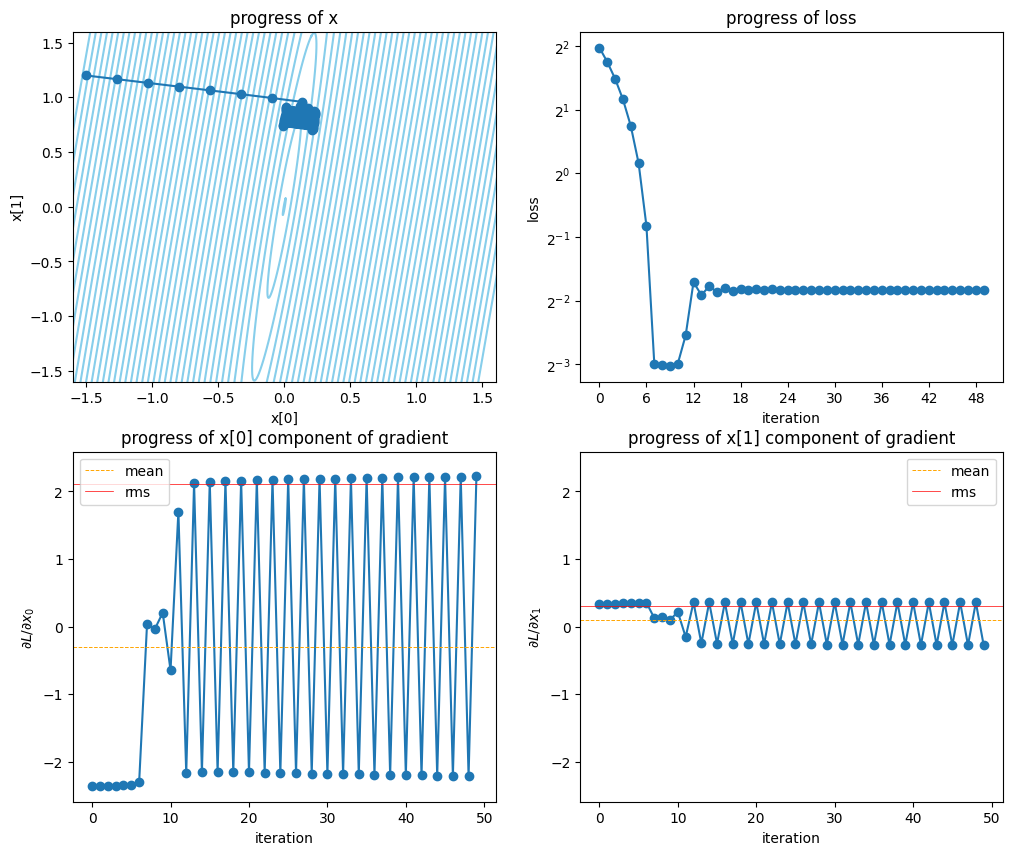

In [6]:
x = torch.tensor([-1.5, 1.2])
x.requires_grad = True # This tells PyTorch that the x variable will be used to calculate gradients.

L = LossFunctionWithPlot()

learning_rate = 0.1
optimizer = torch.optim.SGD([x], lr=learning_rate)
grads = []

for iter in range(50):
    loss = L(x)
    loss.backward()
    with torch.no_grad():
        optimizer.step()
    grads.append(x.grad.clone())
    optimizer.zero_grad()

grads = torch.stack(grads)

###################################################################################
# TODO: compute mean derivatives and root mean square derivatives for x[0] and x[1]
###################################################################################

mean_grads = grads.mean(dim=0) # should be computed as a pair of means, one for each dimesnion
rms_grads = (grads ** 2).mean(dim=0).sqrt() # should be computed as a pair of root-mean-squares, one for each dimension

################################################################################
#                             END OF YOUR CODE                                 #
################################################################################

print('Mean grads for two dimensions separately:', mean_grads)
print('Root mean square grads for two dimensions separately:', rms_grads)

L.plot_history(grads=grads, mean_grads=mean_grads, rms_grads=rms_grads)

<font size='4'>**Facts about mean and RMS**</font>

To understand the role of the mean and RMS, answer the following questions.

<font size='4' color='red'>**2.C) Inline Question (4 points):**</font>

$$\text{1. When they differ, which is guaranteed to be smaller: mean or RMS?} = mean$$

$$\text{2. Which is a better representation of the "average size", mean or RMS?} = RMS$$

$$\text{3. When the derviative is consistently positive, will the mean tend to be larger or smaller?} = larger$$

$$\text{4. When the derviative sign changes frequently, will the mean tend to be larger or smaller?} = smaller$$


<font size='4'>**Anticipating problems in optimization using Mean and RMS**</font>

Based on the problems we are seeing, we want the optimizer to slow down when the mean is much smaller than the RMS, and speed up when the mean and RMS are about the same size.  That will:

  1. Make sure the updates to be **small enough** when the gradient starts becoming bumpy, instead of oscillating.
  2. Make sure the updates to be **large enough** when gradient is smooth but happens to be small.
  
The mean and RMS of the gradient can be used to deal with both these problems.  In the next section, we will see how they are directly applied in the ADAM optimizer.


<font size='4'>**The idea of the ADAM optimizer**</font>

The ADAM optimizer automatically chooses a different learning rate for each parameter by using a heuristic that shrinks the update size in regions where the gradient is changing more quickly, while normalizing the update size so that it is a consistent size even in regions where the gradient is very small.  Update magnitudes are calculated per-parameter, so ADAM can help deal with parameters that behave very differently from each other.


The idea behind ADAM is to choose an update that is proportional to a fraction between a weighted mean of the gradient and a weighted RMS of the gradient:

$$\Delta x = - \alpha \frac{\text{mean gradient}}{\text{rms gradient}} = - \alpha \frac{\sum_i w_i g_i}{\sqrt{\sum_i u_i g_i^2}}$$

In the definition above, the $g_i$ are samples of the gradient from previous steps, and $w_i$ and $u_i$ are the weights to use for averaging.

Why one might divide the mean gradient by the RMS of the gradient?

To understand, answer the following question.


<font size='4' color='red'>**2.D) Inline Question (2 points):**

Suppose there is a new problem which is scaled by some constant $K$ so that all the new gradients are uniformly scaled larger. We want to understand whether ADAM speeds up or slows down when gradients are scaled up. Precisely: If gradients $\hat{g}_i=Kg_i$ are scaled up with $K>1$, how will the ADAM update $\Delta\hat{x}$ relate to the original problem's ADAM update $\Delta x$ i?  (e.g., which is larger?) </font>

**Answer.**

They should be the same as both the numerator and denomenator are scaled up by the same factor.

This property means that ADAM will not go too fast nor too slow just because the average size of the gradient is too large.  The only thing that will cause ADAM to slow down is when the mean is much smaller than the RMS, which happens when the gradient frequently changes sign, for example, when the optimizer is oscillating around a minima.

Because the mean and RMS will change during the optimization, in practice the ADAM algorithm is based on using **exponential moving averages** which will adapt as optimization proceeds.

<font size='4'>**II) Exponential Moving Average (EMA) on Time Series Data**</font>

The exponential Moving Average (EMA) represents a moving average variant that assigns greater importance to the most recent data points within a time series. It achieves this by progressively diminishing the influence of older data points. Unlike simple moving averages, where all data points hold the same weight, EMA's differential weighting scheme enhances its sensitivity to recent data alterations, rendering it highly attuned to the latest fluctuations within the data.

EMA is a weighted average where, the weight of a sample of age $t-i$ is decayed exponentially by $\beta^{(t-i)}$, where $\beta < 1$ is the smoothing parameter.  That is, using geometric series identities,

$$\text{EMA}_t = \frac{\beta^{t-1} x_1 + \beta^{t-2} x_1 + ... + \beta x_{t-1} + x_t}{\beta^{t-1} + \beta^{t-2} + ... + \beta + 1} = \frac{(1 - \beta) \cdot \sum_i \beta^{t-i}x_i}{1 - \beta^{t}}$$

As $t$ gets large, the denominator becomes indistinguishable from one, and EMA can be estimated by computing just the numerator $\text{EMA}_t^* = (1 - \beta) \cdot \sum_i \beta^{t-i}x_i$.  The numerator has the advantage that maintaining a running average only requires a single number be remembered: the most recent numerator $\text{EMA}_{t-1}^*$.  The formula for calculating the numerator $\text{EMA}_t^*$ is as follows:

\begin{align*}
\text{EMA}_0^* &= 0 \\
\text{EMA}_t^* &= \beta \cdot \text{EMA}_{t-1}^* + (1 - \beta) \cdot x_t
\end{align*}

When $t$ is small, the numerator can be much smaller than one, so it must be included, so the full formula for the EMA is:

\begin{align*}
\text{EMA}_t = \frac{\text{EMA}_t^*}{1 - \beta^{t}}
\end{align*}

Where,

- $\text{EMA}_t$ - is the Exponential Moving Average at time t.
- $\text{EMA}_t^*$ - is the Exponential Moving Average Numerator, which $\approx \text{EMA}_t$ when $t$ is large.
- $x_t$ - is the data point at time t that you want to include in the EMA calculation.
- $\text{EMA}_{t−1}^*$ - is the EMA numerator calculated at the previous time step t−1.
- $\beta$ is the smoothing factor

<font size='4' color='Red'>Task 2.2 Implement EMA (2 points)</font>

Based on the definitions above, implement ema_update below, and produce the plot of the EMA of the synthetic time series data.

As you can see, unlike the orindary mean, EMA adapts to changes in the data over time.

Also notice the difference between EMA* and EMA at the beginning of the series.  Notice that EMA* is not unbiased: instead it has a clear bias towards zero.


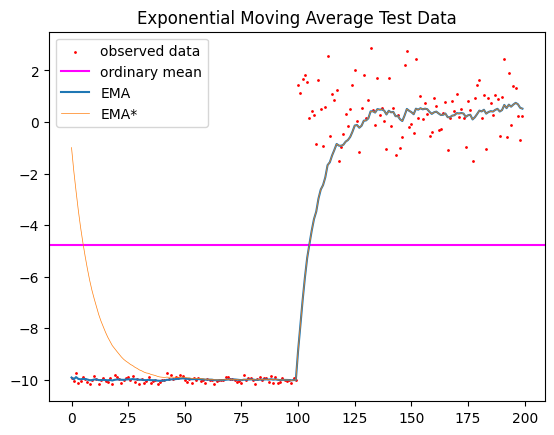

In [7]:
def ema_update(x_t, beta, t, ema_star_old):
    ema_star_t = 0.0
    ema = 0.0
    ############################################################################
    # TODO: 1) compute ema_star_t from ema_star_old, beta, and x_t.
    #       2) compute ema from ema_star_t, beta, and t
    ############################################################################

    ema_star_t = ema_star_old * beta + x_t * (1 - beta) # without bias correction, it would be large while start
    ema = ema_star_t / (1 - beta ** t) # denomnator will be close to 1 when t is large

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return ema, ema_star_t

timestamps = 100
time_series = torch.cat([
    torch.randn(timestamps) * 0.1 - 10.0,
    torch.randn(timestamps) + 0.5,
])
mean = time_series.mean()


beta = 0.9
ema_star = 0.0
history, history_star = [], []

for t, d in enumerate(time_series):

    # This is the ema update
    ema, ema_star = ema_update(d, beta, t+1, ema_star)
    history.append(ema)
    history_star.append(ema_star)

plt.title('Exponential Moving Average Test Data')
plt.scatter(range(len(time_series)), time_series, s=1, color='red', label='observed data')
plt.axhline(mean, label='ordinary mean', color='magenta')
plt.plot(history, label='EMA')
plt.plot(history_star, label='EMA*', linewidth=0.5)
plt.legend()
plt.show()

<font size='4'>**III) ADAM Optimizer**</font>

ADAM (Adaptive Moment Estimation) is a popular optimization algorithm used for training machine learning and deep learning models.  ADAM is known for its efficiency, robustness, and ability to handle a wide range of optimization problems.

Here are the key components and features of the ADAM optimizer:

- Adaptive Learning Rates: ADAM adapts the learning rates for each parameter during training. It maintains a separate learning rate for each parameter based on the historical gradients of that parameter. This adaptability helps the algorithm converge faster and handle sparse gradients effectively.

- EMA Momentum: ADAM incorporates the concept of momentum, similar to the SGD with momentum optimizer. It uses exponential moving averages of past gradients to help the optimization process. This momentum term smooths the optimization trajectory and accelerates convergence.

The update rule for ADAM is as follows:

\begin{align*}
m_t^* & = \beta_1 \cdot m_{t-1}^* + (1 - \beta_1) \cdot g_t & & \text{(First Moment)} \\
m_t & = \frac{m_t^*}{1 - \beta_1^t} & &\text{(Bias correction)} \\
v_t^* & = \beta_2 \cdot v_{t-1}^* + (1 - \beta_2) \cdot g_t^2 & & \text{(Second Moment)} \\
v_t & = \frac{v_t^*}{1 - \beta_2^t} & & \text{(Bias correction)} \\
x_{t+1} & = x_t - \alpha \cdot \frac{{m}_t}{\sqrt{{v}_t} + \epsilon} & &\text{(Parameter Update)}
\end{align*}

Where:

- $m_t$ and $v_t$ - are the EMA estimates of the first and second moments of the gradients at time step t, respectively.
- $\beta_1$ and $\beta_2$ - are exponential decay rates for the first and second moments, typically close to 1
- $g_t$ - is the gradient of the parameter $\theta$ at time step t, which is used to calculate these moving averages.
- $\alpha$ is the learning rate.
- $\epsilon$ is a small constant, just to avoid division-by-zero.

This can also be written as
\begin{align*}
m_t, m_t^* & = \mathtt{ema\_update}(g_t, \beta_1, t, m_{t-1}^*) & &\text{(EMA Update)}\\
v_t, v_t^* & = \mathtt{ema\_update}(g_t^2, \beta_2, t, v_{t-1}^*) & &\text{(EMA Update)} \\
x_{t+1} & = x_t - \alpha \cdot \frac{{m}_t}{\sqrt{{v}_t} + \epsilon} & &\text{(Parameter Update)}
\end{align*}

As a final detail, we can incorporate weight decay by defining $g_t$ to include the weight decay term as worked out in a previous exercise.

<font size='4' color='Red'>Task 2.3 - Implement the ADAM optimizer (_ points)</font>

Now implement your own ADAMOptimizer, using the following code as a starting point.

 * Within the loop, you can use `ema_update` to make the code simpler.
 * Remember that there are two smoothing factors, `beta_1` and `beta_2`.
 * Remember to incorporate hyperparameters `learning rate`, `epsilon`, and `weight_decay`

You can test your code by swapping between `torch.optim.Adam` and your own `ADAMOptimizer`.  On this test, they should behave the same.

Loss at step 0 is 3.937
Loss at step 7 is 2.054
Loss at step 14 is 0.186
Loss at step 21 is 0.605
Loss at step 28 is 0.100
Loss at step 35 is 0.162
Loss at step 42 is 0.090
Loss at step 49 is 0.027


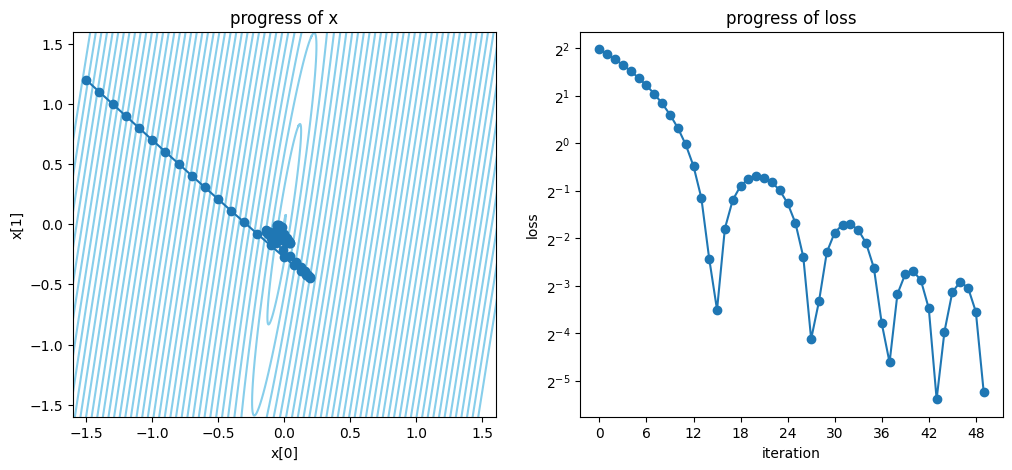

In [70]:
class ADAMOptimizer():
    def __init__(self, parameters, lr=0.1, betas=[0.9, 0.999], eps=1e-8, weight_decay=0.0):
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        # t is a running timestamp.
        self.t = 0
        self.parameters = []
        self.m_star = []
        self.v_star = []
        for x in parameters:
          # if x.requires_grad: # For transfer learning, only consider parameters that require gradients
          self.parameters.append(x)
          self.m_star.append(torch.zeros_like(x))
          self.v_star.append(torch.zeros_like(x))


    def step(self):
        self.t += 1
        with torch.no_grad():
            for x, m_star, v_star in zip(self.parameters, self.m_star, self.v_star):
                g = 0.0
                m, m_star[...] = 0, m_star
                v, v_star[...] = 0, v_star
                ################################################################
                # TODO: Implement ADAM optimization
                #
                # There are three steps:
                # (1) m and m_star are updated to incorporate g with smoothing
                # beta_1 using ema_update(...).
                # (2) v and v_star are updated to incorporate g^2 with smoothing
                # beta_2 using ema_update(...).
                #(3) x is updated according to ratio between the mean and RMS
                # gradient estimates, using lr and epsilon.
                #
                # Remember to advance the timestep t before each step.
                # Remember to update m_star and v_star in-place.
                # There is a difference between saying m_star = something and
                # m_star[...] = something.
                ################################################################
                grad_t = x.grad + self.weight_decay * x
                # For transfer learning
                # if x.grad is not None:
                #   grad_t = x.grad + self.weight_decay * x
                # else:
                #   continue
                m, m_star[...] = ema_update(grad_t, self.beta_1, self.t, m_star)
                v, v_star[...] = ema_update(grad_t**2, self.beta_2, self.t, v_star)

                x -= self.lr * m / (torch.sqrt(v) + self.eps)

                ################################################################
                #                             END OF YOUR CODE                 #
                ################################################################
    def zero_grad(self):
        for x in self.parameters:
            x.grad = None


# TEST CODE BELOW
# 'x' variable = is the current estimate which will be updated iteratively during the optimization.
# 'L' function = the quadratic loss function we will use.  This one can also plot its inputs and outputs.
# 'learning_rate' = is the step size that is used to update the solution

x = torch.tensor([-1.5, 1.2])
x.requires_grad = True # This tells PyTorch that the x variable will be used to calculate gradients.

L = LossFunctionWithPlot()

learning_rate = 0.1
weight_decay = 0.1

# If you switch this for torch.optim.Adam, it should behave exactly the same.
optimizer = ADAMOptimizer([x], lr=learning_rate, weight_decay=weight_decay)

for iter in range(50):
    loss = L(x)
    if iter % 7 == 0: print(f'Loss at step {iter} is {loss.item():.3f}')
    loss.backward()
    with torch.no_grad():
        optimizer.step()
    optimizer.zero_grad()

L.plot_history()

<font size='5'>**Part 3: Training a Neural Network**</font>



<font size='4'>**Tiny Classification Problem**</font>

The following code loads raw data for a tiny classification problem.


The training data has 10000 samples, each a vector of 36 numbers along with
a corresponding set of 10000 labels, assigning 0 or 1 to each sample.
The test data has 2000 samples and labels that are disjoint from the training data.



In [71]:
train_data, train_labels, test_data, test_labels = [
    torch.tensor(m[k]).float()
    for m in [np.load('tiny-classification.npz')]
    for k in 'train_data train_labels val_data val_labels'.split()]

print(f'The training data has {train_data.size(0)} samples, each a vector of {train_data.size(1)} numbers along with')
print(f'a corresponding set of {train_labels.size(0)} labels, assigning {train_labels.min()} or {train_labels.max()} to each sample.')

print(f'The test data has {test_data.size(0)} samples and labels that are disjoint from the training data.')

The training data has 8000 samples, each a vector of 36 numbers along with
a corresponding set of 8000 labels, assigning 0.0 or 1.0 to each sample.
The test data has 1000 samples and labels that are disjoint from the training data.




The following code cell serves the purpose of training a neural network, tracking its performance throughout the training process, and generating visual representations of the training progress. It is crucial for students to grasp the functionality of the `run_test` function and `Supervise` class as it will be frequently utilized in the subsequent tasks.

Comments have been thoughtfully included to enhance code comprehension.

In [72]:
def run_test(net, optmaker, test_every=10):
    # Set up the Loss Function and Optimizer
    optimizer = optmaker(net.parameters()) # Initialize the optimizer with model parameters
    print(f'{sum([p.numel() for p in net.parameters()])} parameters')
    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(2000):
        loss = net(train_data.float(), train_labels.float())
        loss.backward()
        train_losses.append([epoch, loss.item()])
        optimizer.step() # Update model parameters using the optimizer's update rule
        if epoch % test_every == test_every - 1:
            grads = torch.stack([p.grad.abs().max() for p in net.parameters()]) # <=== Adjust it for transfer learning if p is not None
            maxg, ming = grads.abs().max(), grads.abs().min()
            train_outputs = net.net(train_data.float())
            train_preds = (train_outputs.squeeze() > 0.5).float()
            train_accuracy = (train_preds == train_labels).float().mean()
            train_accs.append([epoch + 1, train_accuracy])
            test_outputs = net.net(test_data.float())
            test_preds = (test_outputs.squeeze() > 0.5).float()
            test_accuracy = (test_preds == test_labels).float().mean()
            test_accs.append([epoch + 1, test_accuracy])
            print(f'Epoch {epoch+1}, Loss: {loss.item():.5f}, Grad range {maxg:.1e} to {ming:.1e}, '
                  f'Train Accuracy: {train_accuracy.item()}, Test Accuracy: {test_accuracy.item()}', end='   \r')
            if test_accuracy.item() == 1.0:
                break
        optimizer.zero_grad()

    # Test the Model
    with torch.no_grad():
        train_outputs = net.net(train_data.float())
        train_preds = (train_outputs.squeeze() > 0.5).float()
        train_accuracy = (train_preds == train_labels).float().mean()
        test_outputs = net.net(test_data.float())
        test_preds = (test_outputs.squeeze() > 0.5).float()
        test_accuracy = (test_preds == test_labels).float().mean()
        print(f'\nTrain Accuracy: {train_accuracy.item():.5f}, Test Accuracy: {test_accuracy.item():.5f}')


    # Visulaiztion
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(*zip(*train_losses), label="Training loss")
    ax.set_yscale('log')
    ax2.plot(*zip(*train_accs), color="orange", label="Training accuracy")
    ax2.plot(*zip(*test_accs), color="red", label="Test accuracy")
    ax2.set_ylim(0.0, 1.0)
    for a in [ax, ax2]:
        for pos in 'top right bottom left'.split():
            a.spines[pos].set_visible(False)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    fig.legend(loc="lower left", bbox_to_anchor=(0, 0), bbox_transform=ax.transAxes)
    fig.show()

print(f'Data width {train_data.size(1)}; Constant baseline accuracy {max(test_labels.sum(), len(test_labels) - test_labels.sum()) / len(test_labels):.3f}')

Data width 36; Constant baseline accuracy 0.500


The `Supervise` class is a wrapper that combines a neural network model and a loss function to facilitate supervised learning tasks. It computes the loss by performing a forward pass through the neural network and comparing the predicted values to the true labels.

In [73]:
class Supervise(Module):
    def __init__(self, criterion, net):
        super().__init__()
        self.net = net
        self.criterion = criterion
    def forward(self, x, y):
        out = self.net(x).squeeze()
        return self.criterion(out, y)

<font size='4'>**Here is an example on how to train a model using `Supervise` and `run_test` function**</font>

75521 parameters
Epoch 2000, Loss: 0.24972, Grad range 1.4e-04 to 2.1e-06, Train Accuracy: 0.5302500128746033, Test Accuracy: 0.5199999809265137   
Train Accuracy: 0.53025, Test Accuracy: 0.52000


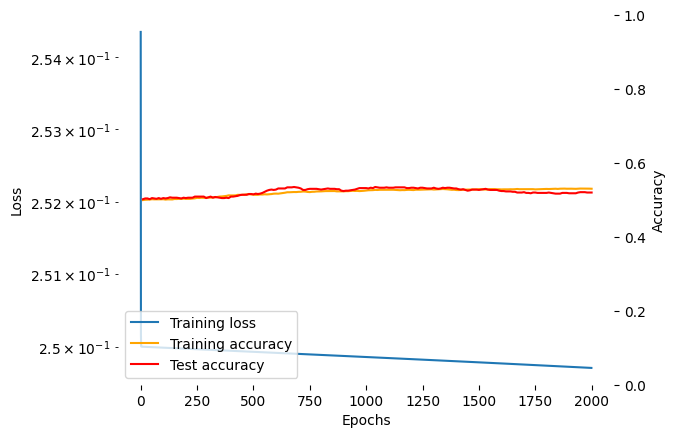

In [76]:
################################################################################
# TODO: Build a Neural Network which has the architecture as follows:-
# Hidden Dimension - 256
# Loss function - Mean Squared Error (MSE)
# Optimizer - Simple GradientDescent (lr=0.1) [Using the optimizer built in Task 1.3]
# Network Architecture - (Linear + Sigmoid) -> (Linear + Sigmoid) -> (Linear +
# Sigmoid)
################################################################################

input_size=train_data.size(1)
hidden_dims= 256
output_dims=1

run_test(
    Supervise(
    nn.MSELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.Sigmoid(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: SimpleGradientDescent(p,lr=0.1)
)
################################################################################
#                             END OF YOUR CODE                                 #
################################################################################

<font size='4'>**Configuring and training various Neural Network Architectures**</font>

Let's construct a range of neural network architectures with varying configurations to explore their impact on training performance when considering factors such as:

- Activation functions
- Choice of optimizers
- Regulariztion
- Hidden layer dimensions
- Network depth
- Batch normalization
- Residual networks.

This experimentation will help us gain insights into how these factors influence the training process on our dataset.

**Note** - Utilize the previously defined `SimpleGradientDescent` and `ADAMOptimizer` optimizers exclusively, unless otherwise specified in the task to employ PyTorch's built-in optimizers.

#### **1) Activation functions**

<font size='4' color='Red'>Task 3.1 - Test sigmoid activations in a three-layer network with `run_Test` (1 point)</font>

Let's apply our new `run_test` function together with your `SimpleGradientDescent` optimizer class to test (assuming that is the class name you gave it).  You will need to put in your three-layer sigmoid network definition to make the example work.


21377 parameters
Epoch 2000, Loss: 0.24789, Grad range 1.5e-02 to 3.6e-04, Train Accuracy: 0.5241249799728394, Test Accuracy: 0.5170000195503235   
Train Accuracy: 0.52412, Test Accuracy: 0.51700


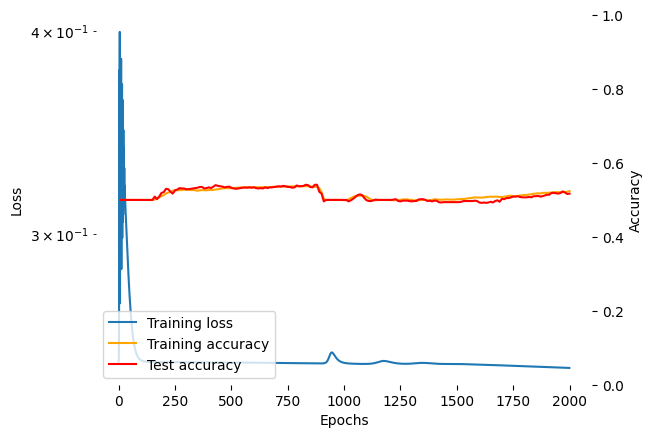

In [77]:
torch.manual_seed(7150) # (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Create an architecture similar to the example but with reduced hidden
# dimension
# Hidden Dimension - 128
# Loss - MSELoss()
# Optimizer - Simple GradientDescent - (lr = 1.0) [Use the Optimizer built above]
# Network Architecture - (Linear + Sigmoid) -> (Linear + Sigmoid) -> (Linear + Sigmoid)
################################################################################
# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 128
output_dims = 1

run_test(
    Supervise(
        nn.MSELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.Sigmoid(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.Sigmoid(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: SimpleGradientDescent(p, lr=1.0)
)

################################################################################
#                             END OF YOUR CODE                                 #
################################################################################


<font size='4' color='Red'>Task 3.2 - Test Tanh activations in a three-layer network (1 point)</font>

Implement the same neural network architecture

Read documentation - https://pytorch.org/docs/stable/generated/torch.nn.Tanh.AC

Now let us compare Sigmoid to other activations.  Switch every `nn.Sigmoid()` to `nn.Tanh()`.  Tanh balances positive and negative outputs and sometimes work better.  Implement and decide whether it is helping in this case.

21377 parameters
Epoch 2000, Loss: 0.18056, Grad range 2.6e-02 to 7.4e-03, Train Accuracy: 0.7253749966621399, Test Accuracy: 0.6769999861717224   
Train Accuracy: 0.72537, Test Accuracy: 0.67700


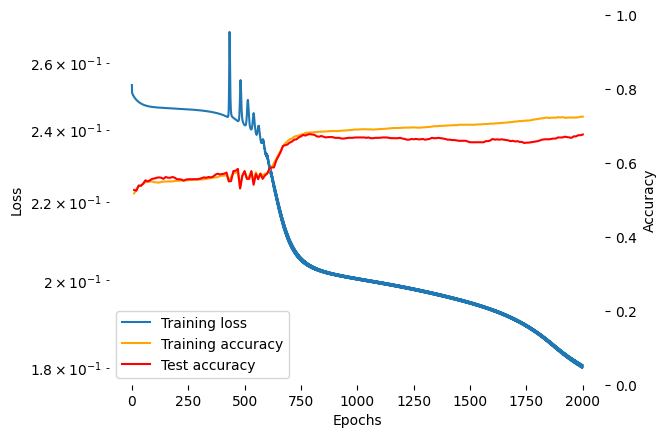

In [78]:
torch.manual_seed(7150) # (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Create an architecture similar to the previous one, but replace every
# nn.Sigmoid() activation function with nn.Tanh() (except for the last one).
# Hidden Dimension - 128
# Loss - MSELoss()
# Optimizer - Simple GradientDescent - (lr = 1.0) [Use the Optimizer built above]
# Network Architecture - (Linear + Tanh) -> (Linear + Tanh) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 128
output_dims = 1

run_test(
    Supervise(
        nn.MSELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.Tanh(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.Tanh(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: SimpleGradientDescent(p, lr=1.0)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='Red'>Task 3.3 - Test ReLU activations in a three-layer network (1 point)</font>

The ReLU activation was studied closely by Glorot, which we have discussed in class.  It tends to be very effective at avoiding  vanishing gradients, because on the positive side it never saturates.  Replace all your nonlinearties with ReLU while keeping the architecture otherwise the same.  Does ReLU help in this case?

21377 parameters
Epoch 2000, Loss: 0.05541, Grad range 2.5e-02 to 1.4e-02, Train Accuracy: 0.921500027179718, Test Accuracy: 0.8309999704360962   
Train Accuracy: 0.92150, Test Accuracy: 0.83100


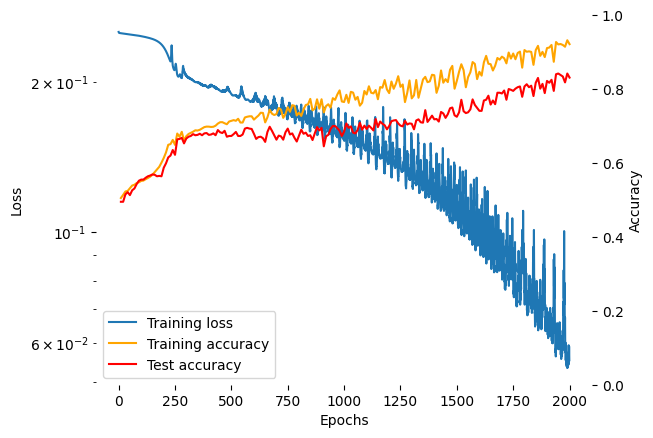

In [30]:
torch.manual_seed(7150) # (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Create an architecture similar to the previous one, but replace every
# nn.Tanh() activation function with nn.ReLU() (except for the last one).
# Hidden Dimension - 128
# Loss - MSELoss()
# Optimizer - SimpleGradientDescent - (lr = 1.0)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
#################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 128
output_dims = 1

run_test(
    Supervise(
        nn.MSELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: SimpleGradientDescent(p, lr=1.0)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='red'>**3.A) Inline Question (1 point):**  
In the above Tasks, we employed three different activation functions—sigmoid, tanh, and relu—in our neural network architecture. Describe the difference in the behavior of the optimization process that you observed between Sigmoid, TanH, and ReLU.  Do your results confirm or contradict the results that Glorot reported in his 2010 study?</font>

My results confirm the results from Glorot, where relu activation shows better performance than both sigmoid and tanh, among which tanh outperforms sigmoid. As we can see from the Sigmoid results, due to the saturation of weights starting from relatively the beginning, the model tends not to learn much in later process. While relu results shows continuous learning of the model throughout the process and loss is converging and accuracy is slowly climbing.

<font size='4' color='Red'>Task 3.4 - Implement Binary Cross Entropy Loss (1 point)</font>

In a classification setting, we often prefer to interpret the outputs as probabilities and drive the probability distribution towards the true distribution.  The standard way to achieve that is to use the cross-entropy loss.  Cross-entropy (as seen in HW1) also test to avoid saturation when compared to MSE, when used in combination with softmax.

Replace the supervision with `BCELoss` rather than mean square error, and observe any differences.

Read documentation for BCE Loss - https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

21377 parameters
Epoch 2000, Loss: 0.06464, Grad range 2.7e-03 to 3.9e-04, Train Accuracy: 0.9882500171661377, Test Accuracy: 0.8209999799728394   
Train Accuracy: 0.98825, Test Accuracy: 0.82100


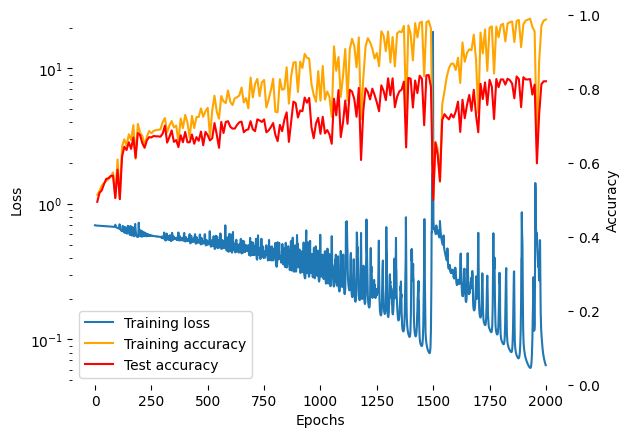

In [31]:
torch.manual_seed(7150) # (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Build a neural network with following architecture:
# Hidden Dimension - 128
# Loss - Binary Cross Entropy
# Optimizer - SimpleGradientDescent - (lr = 1.0)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 128
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: SimpleGradientDescent(p, lr=1.0)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4'>**2) Optimizers**</font>

<font size='4' color='Red'>Task 3.5 Implement using SGD Optimizer (1 point)</font>

So far we have been using our own `SimpleGradientDescent`.  Now try comparing results with pytorch's built-in `torch.optim.SGD` class.  How does your implementation compare?  Is it the same?

Read Documentation for SGD Optimizer using Pytorch - https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

21377 parameters
Epoch 2000, Loss: 0.14078, Grad range 2.4e-02 to 6.6e-03, Train Accuracy: 0.9677500128746033, Test Accuracy: 0.8650000095367432   
Train Accuracy: 0.96775, Test Accuracy: 0.86500


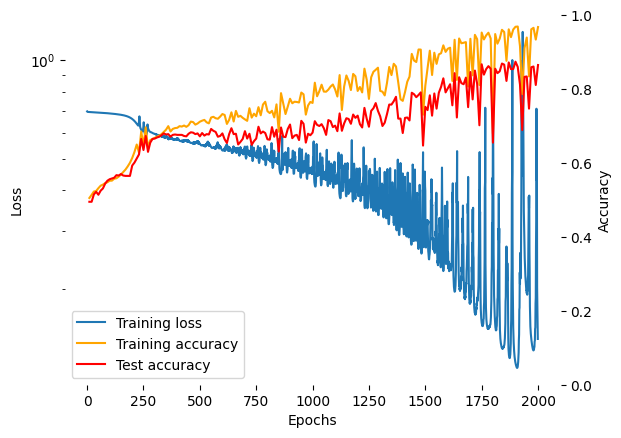

In [32]:
torch.manual_seed(7150) # (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Build a neural network with following architecture, Careful, Hidden
# Dimension has changed.
# Hidden Dimension - 128
# Loss - Binary Cross Entropy
# Optimizer - SGD - (lr = 0.5)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 128
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: torch.optim.SGD(p, lr=0.5)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='Red'>Task 3.6 - ADAM Optimizer (1 point)</font>

ADAM is a very powerful optimizer and should improve results.

Use your own `ADAMOptimizer` class here to see how it behaves.  If you wish to debug against the standard ADAM optimizer, then you can try it out as well, but when you hand in your results, show what your `ADAMOptimzer` does.  Ideally, they should behave the same.

Read Documentation for ADAM Optimizer using Pytorch - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

21377 parameters
Epoch 2000, Loss: 0.00023, Grad range 1.5e-04 to 3.1e-06, Train Accuracy: 1.0, Test Accuracy: 0.5899999737739563   
Train Accuracy: 1.00000, Test Accuracy: 0.59000


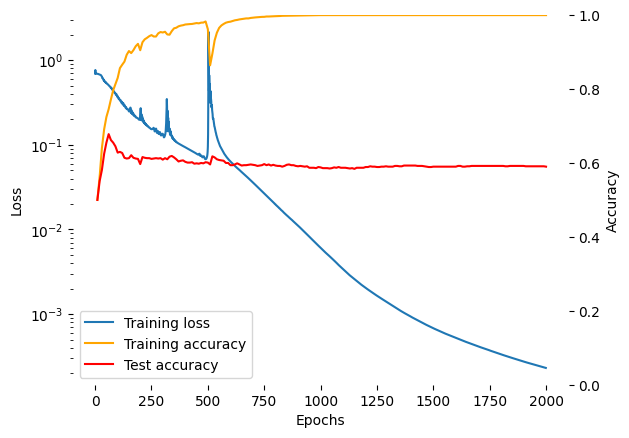

In [15]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Build a neural network with following architecture:
# Hidden Dimension - 128
# Loss - Binary Cross Entropy
# Optimizer - ADAM (weight decay = 0 ,lr = 0.01)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 128
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=0.0)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='red'>**3.B) Inline Question (2 points):** Does ADAMOptimzer do better?  Explain how the optimization behaves differently than you observed with Simple Gradient Descent. </font>

No. The testing accuracy of the model using Adam optimizer 59% is much worse than the model using SGD 86%. The training accuracy of Adam model is 1, which is a strong signal of overfitting.

<font size='4'>**The Battle Against Overfitting**</font>

Let's apply some techniques to enhance and refine our model.

<font size='4'>**A) The Art of Regularization**</font>


<font size='4' color='Red'>Task 3.7 - Add a penalty term to the loss function that discourages large weights. This helps prevent the model from fitting noise in the data. (1 point)</font>



21377 parameters
Epoch 2000, Loss: 0.15025, Grad range 9.0e-03 to 6.7e-05, Train Accuracy: 0.9592499732971191, Test Accuracy: 0.8560000061988831   
Train Accuracy: 0.95925, Test Accuracy: 0.85600


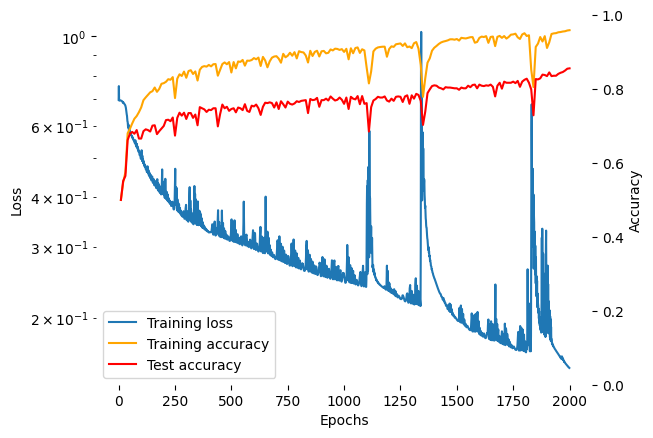

In [16]:
torch.manual_seed(7150) # (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Design a neural network with the specified architecture and introduce a
# regularization term in the loss function to discourage the growth of large
# weights.
# Hidden Dimension - 128
# Loss - Binary Cross Entropy
# Optimizer - Adam with weight decay - (lr = 0.01, weight_decay=1e-3)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 128
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
    # lambda p: torch.optim.Adam(p , lr=0.01, weight_decay=1e-3)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4'>**B) Slimming Down for Success**</font>

Reducing Hidden Dimension - Fewer parameters means that the model has less flexibility to fit the training data and it is forced to learn simpler features that are more likely to generalize to new data.

<font size='4' color='Red'>Task 3.8 - Going Deeper with Shrinking Hidden Dimensions (1 point)</font>

Let's explore the effectiveness of dimension reduction as a technique by reducing the number of hidden dimensions from 128 to 64.

6593 parameters
Epoch 1630, Loss: 0.01917, Grad range 1.4e-02 to 5.1e-04, Train Accuracy: 0.999625027179718, Test Accuracy: 1.0   
Train Accuracy: 0.99963, Test Accuracy: 1.00000


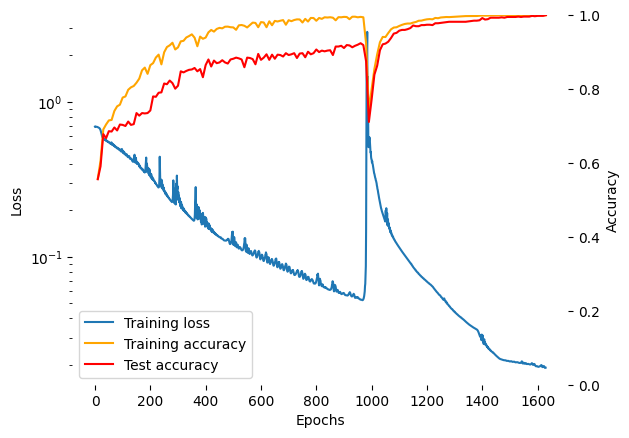

In [17]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Let's create a neural network with following architecture:
# Hidden Dimension - 64
# Loss - Binary Cross Entropy
# Optimizer - Adam with weight decay - (lr = 0.01, weight_decay=1e-3)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 64
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='Red'>Task 3.10 - Going more Deeper with Shrinking Hidden Dimensions (1 point)</font>

Dimension reduction improved our outcome. Let's continue by further reducing the hidden dimension from 64 to 32.


2273 parameters
Epoch 2000, Loss: 0.33807, Grad range 6.5e-02 to 6.4e-03, Train Accuracy: 0.8582500219345093, Test Accuracy: 0.7570000290870667   
Train Accuracy: 0.85825, Test Accuracy: 0.75700


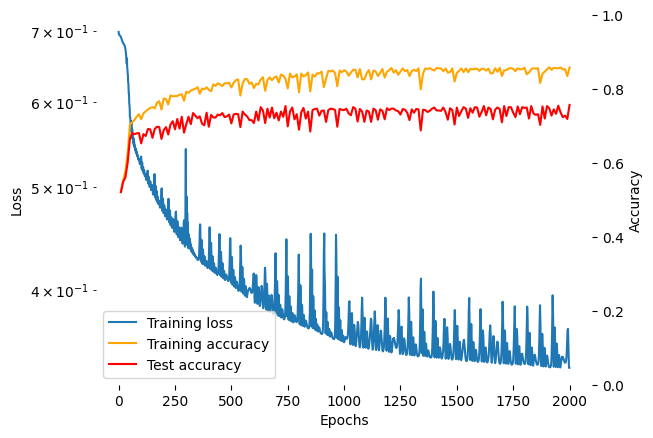

In [18]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Let's create a neural network with following architecture:
# Hidden Dimension - 32
# Loss - Binary Cross Entropy
# Optimizer - Adam with weight decay - (lr = 0.01, weight_decay=1e-3)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 32
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='Red'>Task 3.11 - The Last Shrink (1 point)</font>

Did it help to reduce to 32 dimensions?

Let's try one more time, maybe it will work? (Below, please try reducing the hidden dimension from 32 to 16.)

881 parameters
Epoch 2000, Loss: 0.41792, Grad range 1.8e-02 to 2.8e-03, Train Accuracy: 0.8132500052452087, Test Accuracy: 0.7379999756813049   
Train Accuracy: 0.81325, Test Accuracy: 0.73800


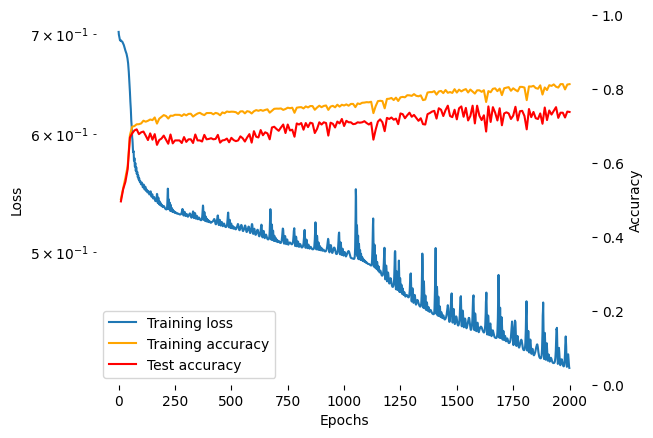

In [19]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
#############################################################################################################
# TODO: Let's create a neural network with following architecture:
# Hidden Dimension - 16
# Loss - Binary Cross Entropy
# Optimizer - Adam with weight decay - (lr = 0.01, weight_decay=1e-3)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
#############################################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 16
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='red'>**3.C) Inline Question**  - In the above Tasks [3.8 - 3.11] (Slimming Down for success) what were your key observations? (1 point)</font>  

Hidden dimensions cannot be too high or too low. High dimensions tends to lead to overfitting and low dimensions don't enable the model to have enough learning. Both of such situations worsen the model performance, so hyper parameter tuning is necessary.

<font size='4'>**C) Layer by Layer**</font>

Increasing the number of layers.

Geoff Hinton likes to assert that deeper layers can capture increasingly abstract and high-level features in the data. This hierarchy allows the network to focus on relevant patterns and discard noise, making it less prone to fitting random variations in the training data.

Is it true?  Let's try it.

<font size='4' color='Red'>Task 3.12 - Increasing the Depth of the network (1 point)</font>

Let's enhance our model by introducing an additional layer, creating a network with four layers.

10753 parameters
Epoch 2000, Loss: 0.00963, Grad range 4.2e-03 to 3.6e-04, Train Accuracy: 1.0, Test Accuracy: 0.9789999723434448   
Train Accuracy: 1.00000, Test Accuracy: 0.97900


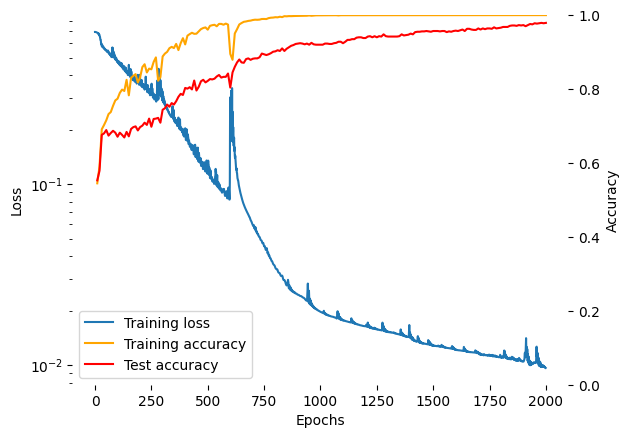

In [20]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Let's create a neural network with following architecture:
# Hidden Dimension - 64
# Loss - Binary Cross Entropy
# Optimizer - Adam (lr = 0.01, weight_decay=1e-3)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + ReLU)
# -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 64
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='Red'>Task 3.13 - Increasing the Depth and reducing the width of the network (1 point)</font>

The recent modification yielded remarkable results. Now, let's take it a step further by enhancing our model's architecture: we'll increase the number of layers from 4 to 6 and reduce the hidden dimension from 64 to 32.

5441 parameters
Epoch 2000, Loss: 0.37876, Grad range 6.5e-01 to 5.9e-02, Train Accuracy: 0.8483750224113464, Test Accuracy: 0.6700000166893005   
Train Accuracy: 0.84838, Test Accuracy: 0.67000


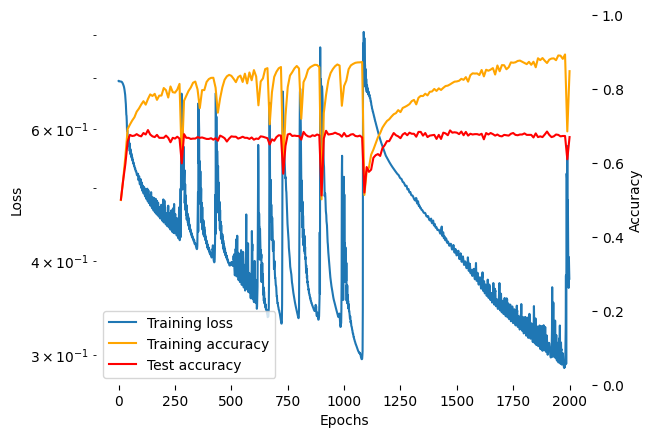

In [21]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Let's create a neural network with following architecture:
# Hidden Dimension - 32
# Loss - Binary Cross Entropy
# Optimizer - Adam with weight decay - (lr=0.005, weight_decay=1e-4)
# Network Architecture - (Linear + ReLU) -> (Linear + ReLU) -> (Linear + ReLU)
#-> (Linear + ReLU) -> (Linear + ReLU) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 32
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.005, weight_decay=1e-4)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4'>**D) Batch Normalization**</font>

Batch Normalization is a technique used to improve the training of deep neural networks. It works by normalizing the activations of each layer, which helps to prevent the network from becoming too sensitive to the initialization of the weights and the order of the training data."

Pytorch documentation - https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d

<font size='4' color='Red'>Task 3.14 Adding Batch Normalization (1 point)</font>

In the previous tasks, our model with a hidden dimension of 32 didn't deliver the desired performance. To address this, let's incorporate Batch Normalization into that architecture and assess whether it can enhance its performance.

Read documentation - https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

5569 parameters
Epoch 2000, Loss: 0.00181, Grad range 2.1e-03 to 3.0e-07, Train Accuracy: 1.0, Test Accuracy: 0.9860000014305115   
Train Accuracy: 1.00000, Test Accuracy: 0.98600


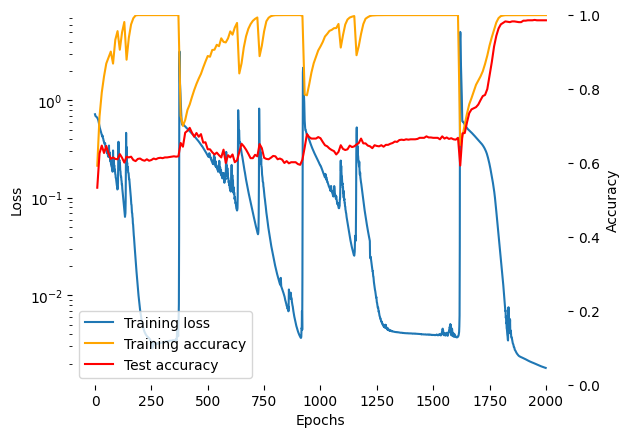

In [22]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: Let's create a neural network with following architecture:
# Hidden Dimension - 32
# Loss - Binary Cross Entropy
# Optimizer - Adam (lr = 0.01, weight_decay=1e-3)
# Network Architecture - (Linear + ReLU + batch_normalization) ->
# (Linear + ReLU) -> (Linear + ReLU) -> (Linear + ReLU) ->
# (Linear + ReLU + batch_normalization) -> (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 32
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dims),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dims),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4'>**E) Residual Networks**</font>

Residual Networks (ResNets) are a type of deep neural network that are designed to address the problem of vanishing gradients.

<font size='4' color='Red'>Task 3.15 - Modifiy the code below so that that `ResidualSequence` does not just implement `y = f(x)` but instead implements `y = f(x) + x`.  The template code has a bug and only implement `y=x`. (1 point)</font>

In [15]:
################################################################################
# TODO: Correct the below code to get f(x) + x as output
################################################################################
class ResidualSequence(Sequential):
    def forward(self, x):
        side_result = super().forward(x)
        final_result= side_result + x
        return final_result
################################################################################
#                             END OF YOUR CODE                                 #
################################################################################

<font size='4'>**Example of Residual Block Architecture**</font>

```
torch.nn.Sequential(
    nn.Linear(train_data.size(1), hidden_dims),
    ResidualSequence(
        nn.ReLU(),
        nn.Linear(hidden_dims, fan_out_dims),
        nn.ReLU(),
        nn.Linear(fan_out_dims, hidden_dims),
    ),
    nn.Linear(hidden_dims, 1),
    nn.Sigmoid()
)
```


<font size='4' color='Red'>Task 3.16 - Implement Residual blocks in a Neural Network architecture (2 point)</font>

Design a neural network with four Residual blocks, each composed according to the specifications outlined below.

4897 parameters
Epoch 2000, Loss: 0.00333, Grad range 4.3e-03 to 5.0e-05, Train Accuracy: 1.0, Test Accuracy: 0.9900000095367432   
Train Accuracy: 1.00000, Test Accuracy: 0.99000


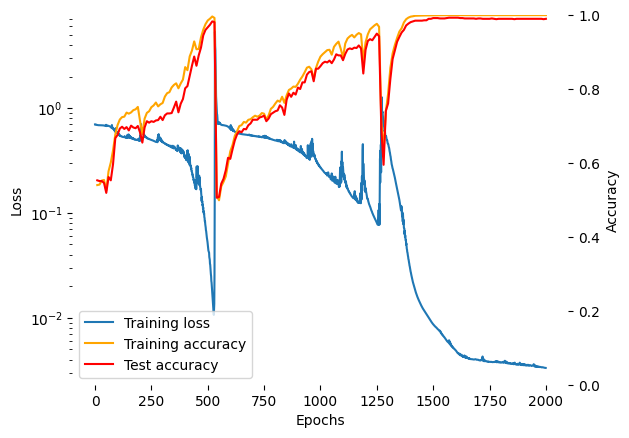

In [24]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
#############################################################################
# TODO: In this task, we will configure a neural network consisting of four
# residual blocks
# Hidden Dimension = 16
# fan_out_dims = 32
# Loss - Binary Cross Entropy
# Optimizer - Adam- (lr=0.01, weight_decay=1e-3)
# Residual Block - [ReLU → Linear → ReLU → Linear]
# Network Architecture - Linear -> Residual Block -> Residual Block ->
# Residual Block -> Residual Block -> (Linear + Sigmoid)
#############################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 16
fan_out_dims = 32
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            ResidualSequence(
                nn.ReLU(),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.ReLU(),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.ReLU(),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.ReLU(),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='Red'>Task 3.17 - Reducing Residual Blocks (2 points)</font>

Let's decrease the number of Residual Blocks and observe whether it has any impact on our performance.

2753 parameters
Epoch 1660, Loss: 0.00244, Grad range 2.9e-03 to 6.2e-05, Train Accuracy: 1.0, Test Accuracy: 1.0   
Train Accuracy: 1.00000, Test Accuracy: 1.00000


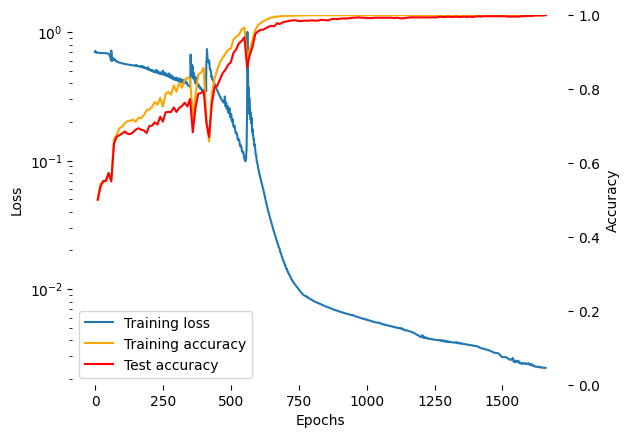

In [25]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
hidden_dims = None
fan_out_dims = None
################################################################################
# TODO: In this task, we will configure a neural network consisting of two
# residual blocks
# Hidden Dimension = 16
# fan_out_dims = 32
# Loss - Binary Cross Entropy
# Optimizer - Adam - (lr=0.01, weight_decay=1e-3)
# Residual Block - [ReLU → Linear → ReLU → Linear]
# Network Architecture - Linear -> Residual Block -> Residual Block ->
# (Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 16
fan_out_dims = 32
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            ResidualSequence(
                nn.ReLU(),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.ReLU(),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='Red'>Task 3.18 Develop a Neural Network with a combination of BatchNorm and Residual Blocks (3 points)</font>

The synergy of these two components often results in improved model performance because BatchNorm stabilizes activations and enables the use of deeper networks, while Residual connections facilitate the training of deep networks and prevent degradation in performance. Together, they can enhance the model's ability to learn intricate patterns and improve its generalization to unseen data. However, it's important to strike a balance and avoid overly complex models, as they may lead to overfitting if not properly regularized.

We will create a neural network incorporating both Batch Normalization and Residual Blocks to evaluate if we can achieve favorable outcomes.

2849 parameters
Epoch 240, Loss: 0.00148, Grad range 1.2e-03 to 3.7e-08, Train Accuracy: 1.0, Test Accuracy: 1.0   
Train Accuracy: 1.00000, Test Accuracy: 1.00000


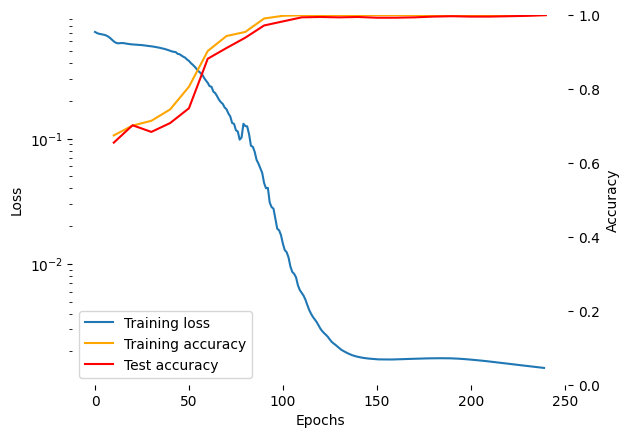

In [26]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)

#############################################################################
# TODO: In this task, we will configure a neural network consisting of two
# residual blocks,
# Hidden Dimension - 16
# fan_out_dims = 32
# Loss - Binary Cross Entropy
# Optimizer - Adam - (lr = 0.01, weight_decay=1e-3)
# Residual Block - [Batch_Norm -> Linear → ReLU → Linear]
# Network Architecture - Linear -> Residual Block -> Residual Block ->
# (Batch_Norm + Linear + Sigmoid)
#############################################################################

# BATCH NORM IS USED TO STABLIZE THE ACTIVATIONS, WHY IS IT FOLLOWING AFTER LINEAR ???
# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 16
fan_out_dims = 32
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims), # double check fan_out_dims
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            nn.BatchNorm1d(hidden_dims),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

# Used far less parameters than the first models

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

<font size='4' color='Red'>Task 3.19 - Develop a neural network that incorporates Batch Normalization, Residual connections, and an increased number of layers. (3 points)</font>

We will construct a neural network with 6 residual blocks to assess whether we can further enhance performance by increasing its depth.

7265 parameters
Epoch 700, Loss: 0.00223, Grad range 2.5e-03 to 4.2e-10, Train Accuracy: 1.0, Test Accuracy: 1.0   
Train Accuracy: 1.00000, Test Accuracy: 1.00000


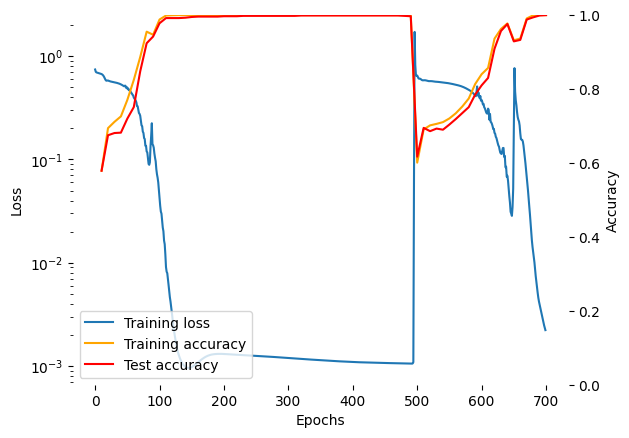

In [27]:
torch.manual_seed(7150)# (Leave it here for deterministic behavior and easier grading)
################################################################################
# TODO: In this task, we will configure a neural network consisting of two
# residual blocks.
# Hidden Dimension - 16
# fan_out_dims = 32
# Loss - Binary Cross Entropy
# Optimizer - Adam - (lr = 0.01, weight_decay=1e-3)
# Residual Block - [Batch_Norm -> Linear → ReLU → Linear]
# Network Architecture - Linear -> Residual Block -> Residual Block ->
# Residual Block -> Residual Block -> Residual Block -> Residual Block
# -> (Batch_Norm + Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size = train_data.size(1)
hidden_dims = 16
fan_out_dims = 32
output_dims = 1

run_test(
    Supervise(
        nn.BCELoss(),
        nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            nn.BatchNorm1d(hidden_dims),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
        )
    ),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

################################################################################
#                             END OF YOUR CODE                                 #
################################################################################

<font size='5'>**Part 4: Weight Initialization**</font>

Weight initialization in deep learning refers to the procedure of assigning initial values to a neural network's weights, which are the tunable parameters learned during training. The manner in which these weights are initialized plays a critical role in shaping the training process and ultimately impacts the network's performance. Several weight initialization techniques have been developed to combat challenges such as vanishing or exploding gradients, with the goal of establishing a solid foundation for training deep neural networks. Some of the weight initialization methods are :-

1. Zero Weight Initialization
2. Random Weight Initialization
3. Xavier Initialization (Glorot Initialization)
4. He Initialization (often used in deep CNN's)

<font size='4'>**1) Zero Initialization**</font>

Zero weight initialization initializes a neural network's weights to zero, which can be effective for specific neural network types. This initialization can mitigate overfitting by making it harder for the model to fit training data perfectly.

However, it has drawbacks. It hinders learning complex input-output relationships from scratch and makes the model sensitive to hyperparameters like the learning rate. This approach is generally discouraged due to the potential emergence of symmetric neurons and slow convergence as a result of weight symmetry issues.

The code visualizes layer-wise activation distributions in a neural network for a Zero Weight Initialization. It offers insights into the network's learning and can reveal potential issues.

<font size='4' color='Red'>Task 4.1 - Initialize zero weights for each layer (_ points)</font>

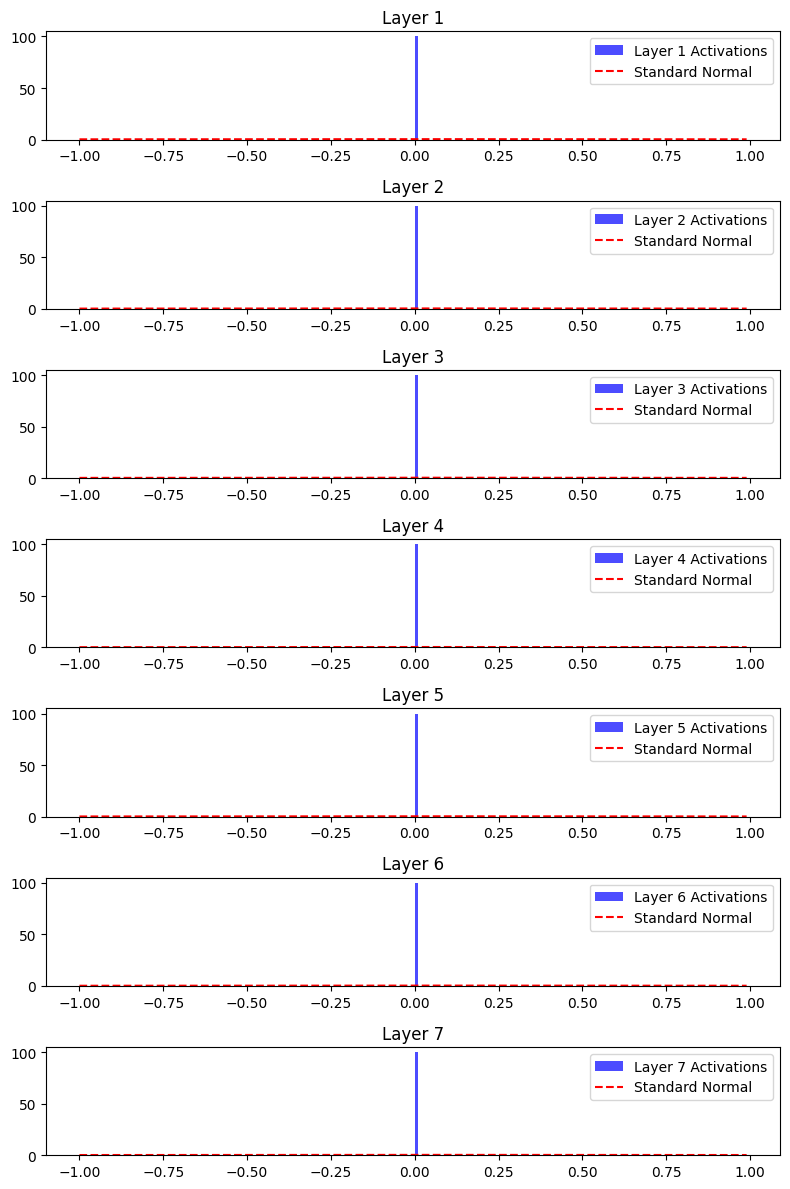

In [14]:
num_layers = 7
layer_dims = [2048]*num_layers

input_data = np.random.randn(16, layer_dims[0])

activations = []

weights = []


for i in range(num_layers - 1):

    ############################################################################
    # TODO - # Initialize zero weights for each layer (except the last one)
    # and store it in 'W' varaiable
    ############################################################################
    if i != 0:
      W = np.zeros((layer_dims[i-1], layer_dims[i]))
    else:
      W = np.zeros((input_data.shape[1], layer_dims[i]))

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    weights.append(W)

# Forward pass through the network
for i in range(num_layers):
    W = weights[i] if i < num_layers - 1 else None
    layer_input = input_data if i == 0 else activations[i - 1]
    if W is not None:
        layer_output = np.tanh(np.dot(layer_input, W))
    else:
        layer_output = layer_input
    activations.append(layer_output)

# Create a figure with subplots for each layer's activation distribution
fig, axes = plt.subplots(num_layers, 1, figsize=(8, 12))

x_axis = np.arange(-1, 1, 0.01)

for i in range(num_layers):
    ax = axes[i]
    ax.hist(activations[i].flatten(), bins=100, density=True, alpha=0.7, color='blue', label=f'Layer {i+1} Activations')
    ax.plot(x_axis, norm.pdf(x_axis, 0, 1), color='red', linestyle='--', label='Standard Normal')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()

<font size='4' color='red'>**4.A) Inline Question (2 points):** Have you noticed any of the drawbacks in the results mentioned earlier? If so, please highlight your observations.</font>  

The forward pass for all layers produce zero activations, so the network is basically nontrainable.

<font size='4'>**2. Random Weight Initialization**</font>

Random Weight Initialization in deep learning sets the initial weights of a neural network to random values, drawn from a distribution. It's simple and encourages diverse starting points for training, breaking symmetry among neurons. However, it can lead to vanishing/exploding gradients in deep networks, making it less effective for them. It's sensitive to initialization values and lacks control compared to specialized methods like Xavier or He initialization.

<font size='4' color='Red'>Task 4.2 Initialize Random weights for each layer (_ points)</font>

The below code visualizes layer-wise activation distributions for a Random Weight Initialization in a neural network. It offers insights into the network's learning and can reveal potential issues.

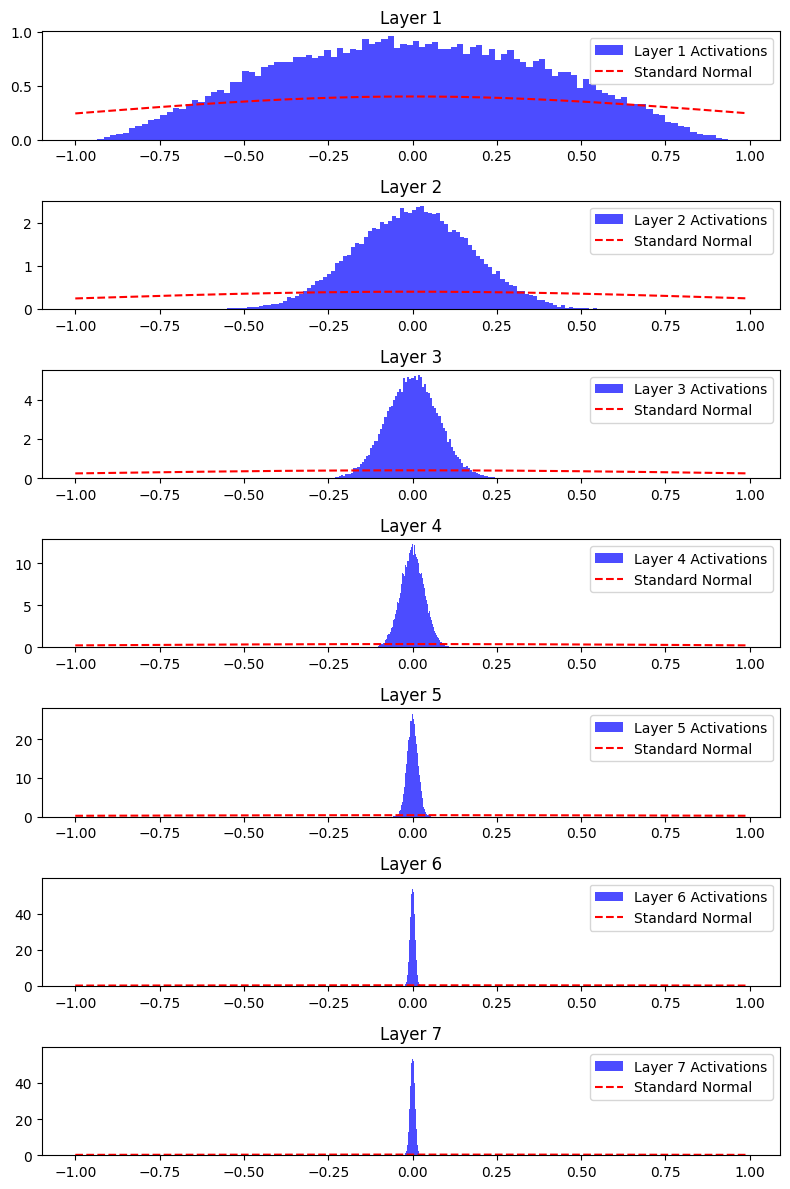

In [15]:
# Define the number of layers and their dimensions
num_layers = 7
layer_dims = [2048]*num_layers

input_data = np.random.randn(16, layer_dims[0])

activations = []

weights = []


for i in range(num_layers - 1):

    ############################################################################
    # TODO - # Initialize random weights for each layer (except the last one)
    # and the store value in 'W' variable
    ############################################################################
    if i != 0:
      W = np.random.randn(layer_dims[i-1], layer_dims[i])
    else:
      W = np.random.randn(input_data.shape[1], layer_dims[i])
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    weights.append(W*0.01)

# Forward pass through the network
for i in range(num_layers):
    W = weights[i] if i < num_layers - 1 else None
    layer_input = input_data if i == 0 else activations[i - 1]
    if W is not None:
        layer_output = np.tanh(np.dot(layer_input, W))
    else:
        layer_output = layer_input
    activations.append(layer_output)

# Create a figure with subplots for each layer's activation distribution
fig, axes = plt.subplots(num_layers, 1, figsize=(8, 12))

x_axis = np.arange(-1, 1, 0.01)

for i in range(num_layers):
    ax = axes[i]
    ax.hist(activations[i].flatten(), bins=100, density=True, alpha=0.7, color='blue', label=f'Layer {i+1} Activations')
    ax.plot(x_axis, norm.pdf(x_axis, 0, 1), color='red', linestyle='--', label='Standard Normal')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()

<font size='4' color='red'>**4.B) Inline Question (2 points):** We can see all the activations tend to zero for deeper network layers. what can be expected regarding the gradients dL/dW, and is there still potential for learning?</font>  

When the activations are near zero, as we are using tanh for activation, the gradients also tend to be very small close to zero as the network becomes deeper. When gradients are small, weight updates are also small. This can lead to very slow convergence or the network getting stuck during training. But even if gradients are vanishing, it doesn't mean learning is impossible, but it's certainly less efficient. Training can take a very long time, or the network may not converge to a useful solution.

I can hear you all say try increasing weights which might resolve the issue. So, let's proceed by multiplying our weights by a factor of 5 and see if it helps.

<font size='4' color='Red'>Task 4.3 - Initialize large Random weights for each layer (_ points)</font>

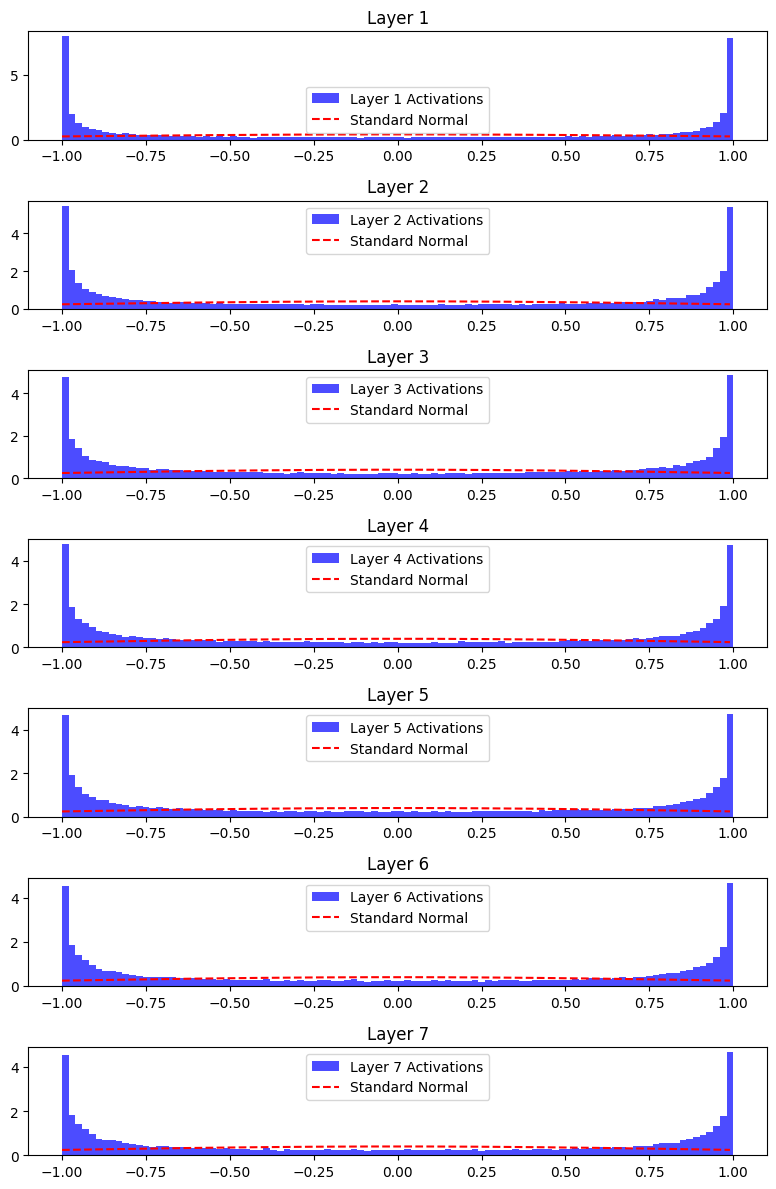

In [16]:
num_layers = 7
layer_dims = [2048]*num_layers

input_data = np.random.randn(16, layer_dims[0])

activations = []

weights = []


for i in range(num_layers - 1):

    ############################################################################
    # TODO - # Initialize random weights for each layer similar to the last
    # task but here you scale them up by a factor of 5
    ############################################################################
    if i != 0:
      W = 5 * np.random.randn(layer_dims[i-1], layer_dims[i])
    else:
      W = 5 * np.random.randn(input_data.shape[1], layer_dims[i])
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    weights.append(W*0.01)

# Forward pass through the network
for i in range(num_layers):
    W = weights[i] if i < num_layers - 1 else None
    layer_input = input_data if i == 0 else activations[i - 1]
    if W is not None:
        layer_output = np.tanh(np.dot(layer_input, W))
    else:
        layer_output = layer_input
    activations.append(layer_output)

# Create a figure with subplots for each layer's activation distribution
fig, axes = plt.subplots(num_layers, 1, figsize=(8, 12))

x_axis = np.arange(-1, 1, 0.01)

for i in range(num_layers):
    ax = axes[i]
    ax.hist(activations[i].flatten(), bins=100, density=True, alpha=0.7, color='blue', label=f'Layer {i+1} Activations')
    ax.plot(x_axis, norm.pdf(x_axis, 0, 1), color='red', linestyle='--', label='Standard Normal')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()

<font size='4' color='red'>**4.C) Inline Question (2 points):**All activations saturate due to big weights. What can be expected regarding the gradients dL/dW, and is there still potential for learning?</font>  

As we can see from above, activations saturate around -1 and 1 because of tanh activation.The gradients will be larger, which can cause large weight updates during training. The learning process will be veru unstable and the model may not be able to converge.

<font size='4'>**3. Xavier Initialization**</font>

Xavier Initialization, also called Glorot Initialization, is a weight initialization method for deep neural networks. It sets initial weights to prevent vanishing and exploding gradients by controlling the variance of activations.This technique stabilizes training and is widely used in practice.

The weights are initialized from a Gaussian distribution with a mean of 0 and a variance of (1/$n_{in}$) :-


\begin{equation}
\mathbf{W} = \mathcal{N}\left(0, \frac{1}{n_\text{in}}\right)
\end{equation}


The below code visualizes layer-wise activation distributions for a Xavier Weight Initialization in a neural network. It offers insights into the network's learning and can reveal potential issues.


<font size='4' color='Red'>Task 4.4 - Initialize weights using Xavier method for each layer (1 point)</font>

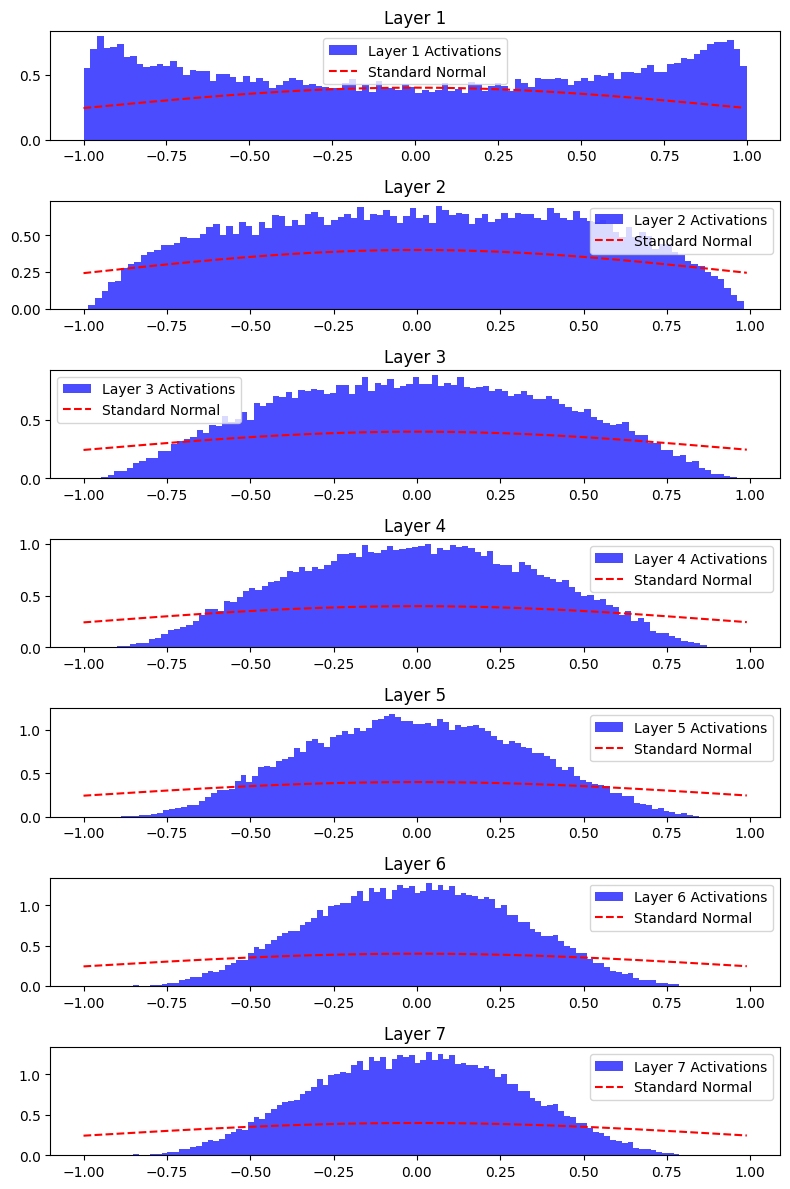

In [17]:
num_layers = 7
layer_dims = [2048]*num_layers

input_data = np.random.randn(16, layer_dims[0])
activations = []
weights = []


for i in range(num_layers - 1):

    ############################################################################
    # TODO - Initialize weights using Xavier method for each layer (except the
    # last one) and store in variable 'W'
    ############################################################################
    if i != 0:
      W = np.random.randn(layer_dims[i-1], layer_dims[i]) * np.sqrt(1/layer_dims[i-1])
    else:
      W = np.random.randn(input_data.shape[1], layer_dims[i]) * np.sqrt(1/input_data.shape[1])
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    weights.append(W)

# Forward pass through the network
for i in range(num_layers):
    W = weights[i] if i < num_layers - 1 else None
    layer_input = input_data if i == 0 else activations[i - 1]
    if W is not None:
        layer_output = np.tanh(np.dot(layer_input, W))
    else:
        layer_output = layer_input
    activations.append(layer_output)

# Create a figure with subplots for each layer's activation distribution
fig, axes = plt.subplots(num_layers, 1, figsize=(8, 12))

x_axis = np.arange(-1, 1, 0.01)

for i in range(num_layers):
    ax = axes[i]
    ax.hist(activations[i].flatten(), bins=100, density=True, alpha=0.7, color='blue', label=f'Layer {i+1} Activations')
    ax.plot(x_axis, norm.pdf(x_axis, 0, 1), color='red', linestyle='--', label='Standard Normal')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()


<font size='4'>**4. He/ MSRA Initialization**</font>

It is a weight initialization technique commonly used in deep neural networks. It is designed to address the vanishing gradient problem and is particularly effective when Rectified Linear Unit (ReLU) activation functions are used.

For a layer with $n_{in}$ input units, He Initialization initializes the weights by sampling them from a Gaussian distribution with a mean of 0 and a variance of 2 / $n_{in}$. The choice of variance (2) is specific to the ReLU activation function and ensures that the weights are set to values that allow ReLU units to activate in a desirable range.

The formula for He Initialization can be expressed as follows:

\begin{equation}
\mathbf{W} = \mathcal{N}\left(0, \frac{2}{n_\text{in}}\right)
\end{equation}


The below code visualizes layer-wise activation distributions for a HE/ MSRA Weight Initialization in a neural network. It offers insights into the network's learning and can reveal potential issues.


<font size='4' color='Red'>Task 4.5- Initialize weights using Kaiming He's method for each layer (1 point)</font>

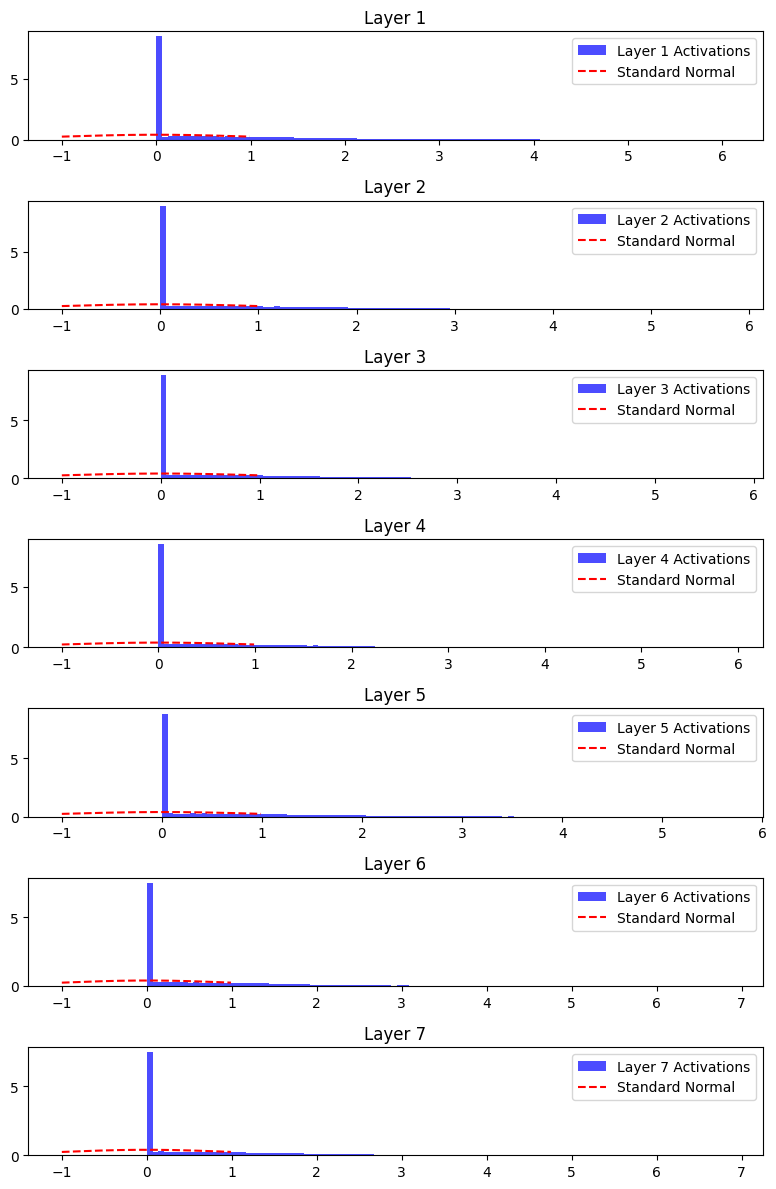

In [18]:
num_layers = 7
layer_dims = [2048]*num_layers

input_data = np.random.randn(16, layer_dims[0])

activations = []

weights = []

for i in range(num_layers - 1):

    ############################################################################
    # TODO - Initialize weights using He method for each layer (except the
    # last one) and store in variable 'W'
    ############################################################################
    if i != 0:
      W = np.random.randn(layer_dims[i-1], layer_dims[i]) * np.sqrt(2/layer_dims[i-1])
    else:
      W = np.random.randn(input_data.shape[1], layer_dims[i]) * np.sqrt(2/input_data.shape[1])
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    weights.append(W)

# Forward pass through the network
for i in range(num_layers):
    W = weights[i] if i < num_layers - 1 else None
    layer_input = input_data if i == 0 else activations[i - 1]
    if W is not None:
        layer_output = np.maximum(0, layer_input.dot(W))
    else:
        layer_output = layer_input
    activations.append(layer_output)

# Create a figure with subplots for each layer's activation distribution
fig, axes = plt.subplots(num_layers, 1, figsize=(8, 12))

x_axis = np.arange(-1, 1, 0.01)

for i in range(num_layers):
    ax = axes[i]
    ax.hist(activations[i].flatten(), bins=100, density=True, alpha=0.7, color='blue', label=f'Layer {i+1} Activations')
    ax.plot(x_axis, norm.pdf(x_axis, 0, 1), color='red', linestyle='--', label='Standard Normal')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()


### <font size='4'>**5. Custom Weight Initialization in Pytorch**</font>

Custom weight initialization in PyTorch involves setting the weights of a neural network to user-defined values. This can serve different purposes, including enhancing model performance or preventing overfitting.

In PyTorch, you can achieve custom weight initialization using the init module, which offers various weight initialization techniques like normal_, uniform_, and kaiming_normal_.

Read Documentation for more information - https://pytorch.org/docs/stable/nn.init.html



<font size='4'>**An illustration of custom weight initialization for a neural network model using values sampled from a normal distribution.**</font>

```
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)

        self.initialize_weights()

    #Initialize weights with values from a normal distribution
    def initialize_weights(self):
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        
    def forward(self, x):
        pass

model = CustomModel()

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'Parameter name: {name}')
        print(param.data)

```

<font size='4' color='Red'>Task 4.6 - Create a class called `Supervise_random_weights` that defines weight using Random Weight Initialization method. (1 point)</font>


In [90]:
class Supervise_random_weights(nn.Module):
    def __init__(self, criterion, net):
        super().__init__()
        self.net = net
        self.criterion = criterion


        for module in self.net.modules(): # iterate each layer
            if isinstance(module, nn.Linear):
                ################################################################
                # TODO: Set the weights to random values from a normal
                # distribution with a mean of 0 and a standard deviation of 0.01
                ################################################################
                # raise NotImplementedError
                nn.init.normal_(module.weight, mean=0, std=1) #  <=== I tried std = 0.01 and found that the model is not learning

                # it returns training and testing accuracy both 0.5 eactly
                # So i think it might be due to the initial weights are too small, which leads to slower convergence or the model getting stuck
                # I adjust the std to 1 and model shows good performance as below

                ################################################################
                #                       END OF YOUR CODE                       #
                ################################################################

    def forward(self, x, y):
        out = self.net(x).squeeze()
        return self.criterion(out, y)


<font size='4' color='Red'>Task 4.7 - Build a Neural Network architecture as instructed below using the `Supervise_random_weights` class which defines weight Randomly with a mean =0 and std = 0.01 (2 points)</font>


5441 parameters
Epoch 2000, Loss: 0.49299, Grad range 4.7e-01 to 3.2e-02, Train Accuracy: 0.7622500061988831, Test Accuracy: 0.7020000219345093   
Train Accuracy: 0.76225, Test Accuracy: 0.70200


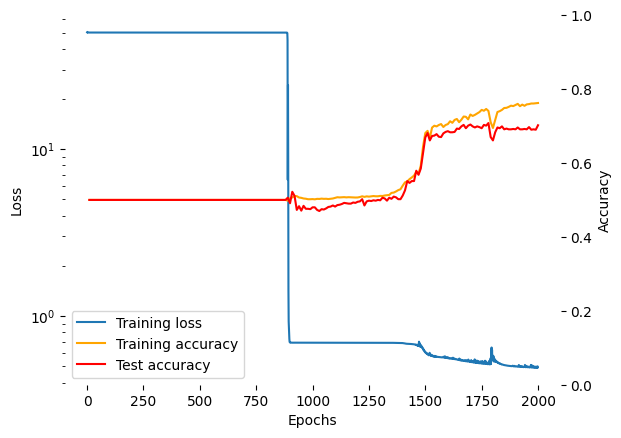

In [91]:

torch.manual_seed(7150)
################################################################################
# TODO: In this task, we will configure a neural network with Supervise_random_weights
# Hidden Dimension = 32
# Loss - Binary Cross Entropy
# Optimizer - Adam - (lr=0.01, weight_decay=1e-3)
# Network Architecture - (Linear + ReLU)-> (Linear + ReLU)->(Linear + ReLU)->
# (Linear + ReLU)->(Linear + ReLU)->(Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size=train_data.size(1)
hidden_dims = 32
output_dims = 1

net = nn.Sequential(
        nn.Linear(input_size, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, output_dims),
        nn.Sigmoid()
    )

model = Supervise_random_weights(nn.BCELoss(), net)

run_test(
    model,
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

################################################################################
#                             END OF YOUR CODE                                 #
################################################################################

<font size='4' color='Red'>Task 4.8 - Create a class called `Supervise_Kaiming_weights` that defines weight using Kaiming He's Weight Initialization method. (1 point)</font>


In [85]:
class Supervise_Kaiming_weights(nn.Module):
    def __init__(self, criterion, net):
        super().__init__()
        self.net = net
        self.criterion = criterion

        for module in self.net.modules():
            if isinstance(module, nn.Linear):
                ################################################################
                # TODO: Set the weights using He initialization
                # [Hint: Python's torch.nn.init.kaiming would be useful].         <=== different attribute should be used!
                ################################################################
                # raise NotImplementedError
                # nn.init.kaiming(module.weight)
                # from pyTorch document:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                ################################################################
                #                       END OF YOUR CODE                       #
                ################################################################

    def forward(self, x, y):
        out = self.net(x).squeeze()
        return self.criterion(out, y)


<font size='4' color='Red'>Task 4.9 - Build a Neural Network architecture as instructed below using the `Supervise_Kaiming_weights` class (2 points)</font>


5441 parameters
Epoch 2000, Loss: 0.30001, Grad range 5.0e-02 to 3.5e-03, Train Accuracy: 0.8818749785423279, Test Accuracy: 0.6690000295639038   
Train Accuracy: 0.88187, Test Accuracy: 0.66900


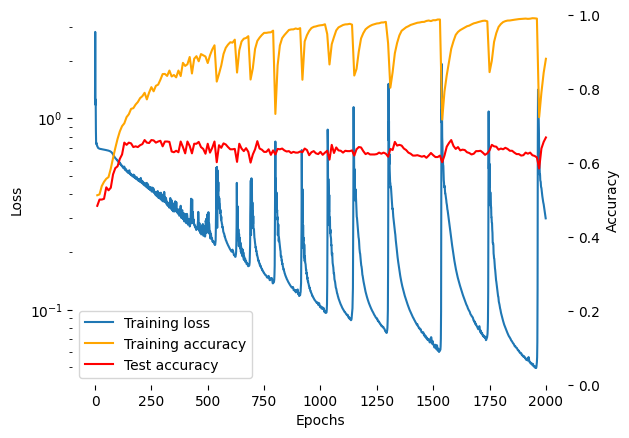

In [86]:
torch.manual_seed(7150)
################################################################################
# TODO: In this task, we will configure a neural network with Supervise_He_weights   <======= Typo Here!!! Kaiming instead.
# Hidden Dimension = 32
# Loss - Binary Cross Entropy
# Optimizer - Adam - (lr=0.01, weight_decay=1e-3)
# Network Architecture - (Linear + ReLU)-> (Linear + ReLU)->(Linear + ReLU)->
# (Linear + ReLU)->(Linear + ReLU)->(Linear + Sigmoid)
################################################################################

# raise NotImplementedError
input_size=train_data.size(1)
hidden_dims = 32
output_dims = 1

net = nn.Sequential(
        nn.Linear(input_size, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims, output_dims),
        nn.Sigmoid()
    )

model = Supervise_Kaiming_weights(nn.BCELoss(), net)

run_test(
    model,
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

############################################################################
#                             END OF YOUR CODE                             #
############################################################################

**Note** - Any idea how does pytorch initialize weights and biases for a layer by default ? Read this discussion - https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073

## <font size='5'>**Extra Credit Questions**</font>

<font size='4'>**Extra Credit Question 1:** (2 points)

Now try to train a network to classify the data in the file `hard-classification.npz`.  This classification problem is very similar to the original one in `tiny-classification.npz`, with inputs that have a very similar structure.  And yet the problem is harder to learn: do the same training techniques work, or is some other approach necessary?  Hint: consider transfer learning or fine-tuning approaches</font>


In [56]:
# set the dataset to train the base model for fine tuning
train_data, train_labels, test_data, test_labels = [
    torch.tensor(m[k]).float()
    for m in [np.load('tiny-classification.npz')]
    for k in 'train_data train_labels val_data val_labels'.split()]

print(f'The training data has {train_data.size(0)} samples, each a vector of {train_data.size(1)} numbers along with')
print(f'a corresponding set of {train_labels.size(0)} labels, assigning {train_labels.min()} or {train_labels.max()} to each sample.')

print(f'The test data has {test_data.size(0)} samples and labels that are disjoint from the training data.')

The training data has 8000 samples, each a vector of 36 numbers along with
a corresponding set of 8000 labels, assigning 0.0 or 1.0 to each sample.
The test data has 1000 samples and labels that are disjoint from the training data.


2849 parameters
Epoch 710, Loss: 0.00106, Grad range 1.5e-03 to 2.9e-08, Train Accuracy: 1.0, Test Accuracy: 1.0   
Train Accuracy: 1.00000, Test Accuracy: 1.00000


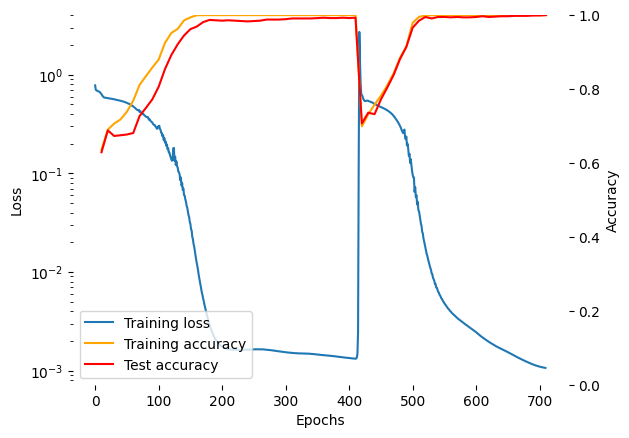

In [57]:
# use the template from 3.19 to train it and save the weights

input_size = train_data.size(1)
hidden_dims = 16
fan_out_dims = 32
output_dims = 1

model = Supervise(
    nn.BCELoss(),
    nn.Sequential(
        nn.Linear(input_size, hidden_dims),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            # ResidualSequence(
            #     nn.BatchNorm1d(hidden_dims),
            #     nn.Linear(hidden_dims, fan_out_dims),
            #     nn.ReLU(),
            #     nn.Linear(fan_out_dims, hidden_dims),
            # ),
            # ResidualSequence(
            #     nn.BatchNorm1d(hidden_dims),
            #     nn.Linear(hidden_dims, fan_out_dims),
            #     nn.ReLU(),
            #     nn.Linear(fan_out_dims, hidden_dims),
            # ),
            # ResidualSequence(
            #     nn.BatchNorm1d(hidden_dims),
            #     nn.Linear(hidden_dims, fan_out_dims),
            #     nn.ReLU(),
            #     nn.Linear(fan_out_dims, hidden_dims),
            # ),
            # ResidualSequence(
            #     nn.BatchNorm1d(hidden_dims),
            #     nn.Linear(hidden_dims, fan_out_dims),
            #     nn.ReLU(),
            #     nn.Linear(fan_out_dims, hidden_dims),
            # ),
            nn.BatchNorm1d(hidden_dims),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
    )
)


run_test(
    model,
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

torch.save(model.net.state_dict(), 'tiny_classification_model.pth')



In [58]:
# Prepare for the hard classification dataset

train_data, train_labels, test_data, test_labels = [
    torch.tensor(m[k]).float()
    for m in [np.load('hard-classification.npz')]
    for k in 'train_data train_labels val_data val_labels'.split()]

print(f'The training data has {train_data.size(0)} samples, each a vector of {train_data.size(1)} numbers along with')
print(f'a corresponding set of {train_labels.size(0)} labels, assigning {train_labels.min()} or {train_labels.max()} to each sample.')

print(f'The test data has {test_data.size(0)} samples and labels that are disjoint from the training data.')

The training data has 8000 samples, each a vector of 36 numbers along with
a corresponding set of 8000 labels, assigning 0.0 or 1.0 to each sample.
The test data has 1000 samples and labels that are disjoint from the training data.


2849 parameters
Epoch 120, Loss: 0.00714, Grad range 5.1e-02 to 1.4e-09, Train Accuracy: 1.0, Test Accuracy: 1.0   
Train Accuracy: 1.00000, Test Accuracy: 1.00000


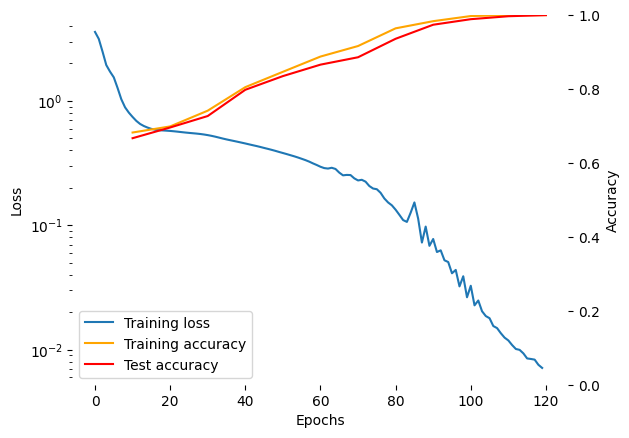

In [59]:

# Tried with six resnet blocks and caused overfitting, so the number of resnet blocks was reduced to only two
# Interesting that when six resnet blocks were used for the tiny dataset, there was no overfitting
# when they were applied to the hard dataset, too many resnet blocks caused overfitting


# Define the base model (without the last layer)
hard_model = nn.Sequential(
    nn.Linear(input_size, hidden_dims),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            ResidualSequence(
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
            ),
            # ResidualSequence(
            #     nn.BatchNorm1d(hidden_dims),
            #     nn.Linear(hidden_dims, fan_out_dims),
            #     nn.ReLU(),
            #     nn.Linear(fan_out_dims, hidden_dims),
            # ),
            # ResidualSequence(
            #     nn.BatchNorm1d(hidden_dims),
            #     nn.Linear(hidden_dims, fan_out_dims),
            #     nn.ReLU(),
            #     nn.Linear(fan_out_dims, hidden_dims),
            # ),
            # ResidualSequence(
            #     nn.BatchNorm1d(hidden_dims),
            #     nn.Linear(hidden_dims, fan_out_dims),
            #     nn.ReLU(),
            #     nn.Linear(fan_out_dims, hidden_dims),
            # ),
            # ResidualSequence(
            #     nn.BatchNorm1d(hidden_dims),
            #     nn.Linear(hidden_dims, fan_out_dims),
            #     nn.ReLU(),
            #     nn.Linear(fan_out_dims, hidden_dims),
            # ),
            nn.BatchNorm1d(hidden_dims),
            nn.Linear(hidden_dims, output_dims),
            nn.Sigmoid()
)

# Load the pre-trained weights into the base model
hard_model.load_state_dict(torch.load('tiny_classification_model.pth'))


run_test(
    Supervise(nn.BCELoss(), hard_model),
    lambda p: ADAMOptimizer(p, lr=0.01, weight_decay=1e-3)
)

# Define the new classifier (last layer)  <======= Also tried only train the top layer parameters, but met some bugs, so I decided to fine tune the whole network
# new_classifier = nn.Sequential(
#     nn.Linear(hidden_dims, output_dims),
#     nn.Sigmoid()
# )

# Combine base model and classifier
# model = nn.Sequential(
#     base_model,
#     new_classifier
# )

# Freeze the base model
# for param in base_model.parameters():
#     param.requires_grad = False

# Run the modified model


<font size='4'>**Extra Credit Question 2:** (4 points)

One of the most serious drawbacks of deep networks is that, even if they can learn to solve a problem and recognize patterns in the data, they might not give us humans much insight about those solutions.  But if we can create a network that solves a problem, it should be possible to understand that solution. As extra credit, figure out: what classification rule did the neural network learn in the above exercises when the network achieves 100% hold-out accuracy?  Can you extract from the network a succinct set of rules that it implements, for example, can you decompile the network into a short python program, that can correctly assign a class to a sample?</font>

$$ \fbox{Answer: _______________}$$